# Step 3  gaze processing


This code was developed and written originally by Debora Nolte. Then extended and adapted by Jasmin L. Walter

In [30]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Preprocessing

## import

In [33]:
import copy  # copy big/deep objects by value
import csv
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import math
import os  # OS operations (read/write files/folders)
import sys
import time
import warnings  # hide warnings
from collections import Counter
from itertools import groupby
import matplotlib

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count
from os.path import exists

import matplotlib.pyplot as plt  # mother of plots focr Python

# import mlxtend
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
# import pyxdf  # read XDF files (LSL streams recordings)

import scipy.stats
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import Markdown, display  # print nicely
from ipywidgets import IntProgress
#from matplotlib.pyplot import cm
from scipy.signal import savgol_coeffs
from tqdm.notebook import tqdm, trange  # mother of progressbars
from scipy.stats import ks_2samp
from multiprocessing import Pool, cpu_count

import scipy.signal

## optimization

In [34]:
# warnings.simplefilter(action="ignore", category=FutureWarning)

# raw and processed data paths
# PATH_RAW = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/27.07.23/data"
# PATH_PROC = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/Events"
# PATH_FOREYE = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/ET_Output_MAD-sacc"
# PATH_TRG = "C:/Users/schmi/Documents/PhD_Osnabruck_University/SpaRe-VR/Spare-VR-EEG/EEG_Data_Skripte_Debbie/TriggerFiles_fEEG"


# specify decimals format on pandas tables
# pd.options.display.float_format = "{:.5f}".format

# inline static plotting (default)
%matplotlib inline
# interactive plotting
# %matplotlib widget

# progress bar customized format
B_FORMAT = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar} 
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} ⚙️{rate_fmt}{postfix}"""


CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")


def pbar_fork_hack():
    """
    Hack to enforce progress bars to be displayed by fork processes on
    IPython Apps like Jupyter Notebooks.

    Avoids [IPKernelApp] WARNING | WARNING: attempted to send message from fork

    Important: pass this function as argument for the initializer parameter
    while initializing a multiprocessing pool to make it work. E.g.:

    pool = Pool(processes=N_CORES, initializer=pbar_fork_hack)

    Source:
     - https://github.com/ipython/ipython/issues/11049#issue-306086846
     - https://github.com/tqdm/tqdm/issues/485#issuecomment-473338308
    """
    print(" ", end="", flush=True)

Total CPU threads: 8


## data paths & participant list

In [35]:
data_savepath_resampled = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step2_resampling"


data_savepath_intermediateP = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_savepath_intervals = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing/intervals"
data_savepath_processed_gazes = "D:/Jasmin/Human_A_Data/Experiment1/Exploration_short/pre-processing/velocity_based/step3_gazeProcessing"

# Getting the Folder without hidden files in ascending order 
# DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
# PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)

# savepath = r'F:\WestbrookProject\SpaRe_Data\pre-processing_2023\step1_preparation\'
# os.chdir(r'F:\WestbrookProject\SpaRe_Data\pre-processed_csv\')

In [36]:
# identify all participants from folder, use this code instead of the participant list based approach
# subIDs = []
# for sub in DATA_FOLDER:
#     if sub[0:4].isdigit() and sub.startswith('1'):
#         subIDs.append(int(sub[0:4]))
#     else:
#         pass
# subIDs = np.unique(subIDs)
# print(subIDs)

In [37]:
# Participant list of all participants that participated 5 sessions x 30 min
# in Westbrook city - HumanA version with agents
PartList = [365, 1754, 2258, 2693, 3310, 4176, 4597, 4796, 4917, 5741, 6642, 7093, 7264, 7412, 7842, 8007, 8469, 8673, 9472, 9502, 9586, 9601]

print(len(PartList),'participants') 

22 participants


In [38]:
# # custom participant list, if only a subset of participants should be processed
# PartList = [1008]

## test code

In [39]:
# # # test code
# file= "1008_Session_1_ET_2_data_interpolated.csv"
# data = pd.read_csv(os.path.join(data_savepath_interpolated, file))
# data.head()


In [40]:
# pd.set_option('display.max_columns', None)

# # # Assuming 'data' is your DataFrame
# data_head = data.tail(15)

# # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
# #     display(data.iloc[100:170])

## test code for figguring out problem for savitzky golay filter

# Gaze Processing


In [41]:
# This will be used to select which version to use
# 1 == MAD_woBig # this is the version we should use (data-driven)
# 2 == 10_sec
define_intervals = 1

# Caluclate angles & velocities

## Calculate the eye-tracking veloctiy

In [42]:
# p.s.
#
# v_gaze_vec(t) = [Xhpoo(t) - Xhpoo(t-1), Yhpoo(t) - Yhpoo(t-1), Zhpoo(t) - Zhpoo(t-1)]
#
# Now we project this velocity onto the plane orthogonal to the viewing
# direction at time t and determine the length. For simplicity we assume
# that all vertical distances are small and keep the plane vertically
# oriented.
#
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||
#
# where <> indicates the scalar product
# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in
# world coordinates.
# v_gaze_inplane is a scalar indicating the velocity in world coordinates
# at the location that is gazed at orthogonal to the gaze axis.
# || ... || indicates the euclidian norm
#
# w_gaze(t) = arctan2(distance(subject(i), hpoo(t)), v_gaze_inplane)
#
# distance(subject(i), hpoo(t)) could be equivalently written as ||
# subject_vec(t) - hpoo_vec(t)||
#
# w_gaze is the instantaneous angular velocity of the eye movement and
# what we want to know.

In [43]:
# note this code calculates the velocity between the rows gaze coordinates
# note 2 the velocity calculation takes the time difference between rows into account, so it should not be affected by the 
# varying sampling rate

def velocity_calc(file, data):

    time = data["timeStampRS"].tolist()

    # get individual coordinates
    # position
    Xcorr_position = data["eyePositionCombinedWorld_x"].tolist()
    Ycorr_position = data["eyePositionCombinedWorld_y"].tolist()
    Zcorr_position = data["eyePositionCombinedWorld_z"].tolist()
    subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

    # hpoo
    hpooX = data["processedCollider_hitPointOnObject_x"].tolist()
    hpooY = data["processedCollider_hitPointOnObject_y"].tolist()
    hpooZ = data["processedCollider_hitPointOnObject_z"].tolist()
   
    hpoo = list(zip(hpooX, hpooY, hpooZ))

    # v_gaze_vec: get difference in hpoo
    v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
    v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
    v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

    # get difference in time:
    ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

    v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

    # gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
    g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
    gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
    # display(np.linalg.norm(gaze_vec[1]))

    # v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
    # v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
    # z1 = (<v_gaze_vec(t), gaze_vec(t)>)
    z1 = [
        np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
        for t in range(len(v_vX))
    ]

    # z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
    z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

    # ||v_gaze_vec(t) - z||
    v_gaze_inplane = [
        np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
        for t in range(len(v_gaze_vec))
    ]
    # w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

    # sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
    sub_hpoo = [
        np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
        for t in range(len(hpoo))
    ]

    # arctan2(v_gaze_inplane, sub_hpoo)
    w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

    # turn angle of radians into degrees
    w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
    # w_gaze = [(w*180/math.pi) for idx,w in enumerate(w_gaze)]


    
    # save df --> to facilitate runtime, save data only in last processing function
    data["combined_vel"] = w_gaze
    
    # 1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data
        

In [44]:
## add new bool variable to identify nan values. Since the first value of a data segment will not have a velocity
# a new variable is needed to successfully index valid data and avoid indexing inconsistencies


def id_valid_data(file, data):
    
    
    nanVels = np.isnan(data["combined_vel"])
    data["validData"] = ~nanVels
    
    return data

In [45]:
### MAXIMUM VELOCITY THRESHOLD (1000deg/sec)
# note: this function just replaces all velocity values exceeding the max threshold of 1000deg/sec with 1000.0. 
# this part should not be affected by the varying sampling rate
 
def max_vel_threshold(file, data):
    
    # max_vel threshold
    max_vel = 1000.0

    combined_vel = data["combined_vel"].tolist()
    c_v = [max_vel if cv > max_vel else cv for cv in combined_vel]
    data["combined_vel"] = c_v
    
#     # save data --> to improve runtime, only save data in last processing function
#     if define_intervals == 1:
#         newName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")
    
    return data
        

# Smooth the Data (Savitzky–Golay)

In [46]:
# Taken from NYSTRÖM AND HOLMQVIST, 2010
# Filter: Savitzky–Golay (sgolay in MATLAB)
# Filter order: 2
# Filter length: 2* min saccade duration Peak

# this might need adjustment, since the sampling rate is taken into consideration for savgol_length...

# also please note: the savitzky_golay filter does not converge if the file starts or ends with
# nan values! The code checks for this case and removes the nan rows for the filtering. 

# also, it cannot handle the remaining nan segments well. It always removes the data from the before and after the 
# nan-data segment by replacing it with NaN values - causing additional data loss and inconsistencies during indexing later
# therefore, the data is split into non-nan value segments and each segment is processed individually to avoid the additional 
# data loss

def savitzky_golay(file, data): 

    # define parameters
    savgol_length = 3  # 0.01 * 90 #window size = int(savgol_length * sr); sr = 90; remodnav = 0.019 -->  int(savgol_length * sr) not possible with our SR
    savgol_polyord = 2  # polynomial order


    combined_vel = data["combined_vel"].values
    
    # identify the non-nan value segments
    nans = ~data["validData"]
    non_nan_segments = np.where(~nans)[0]
    
    if len(non_nan_segments) > 0:
        segment_starts = np.split(non_nan_segments, np.where(np.diff(non_nan_segments) != 1)[0] + 1)
        
        # apply the filter to all segments
        for segment in segment_starts:   
            if len(segment) > savgol_length:
                
                # Apply the Savitzky-Golay filter to the non-NaN segment   
                filtered_segment = scipy.signal.savgol_filter(combined_vel[segment], savgol_length, savgol_polyord)
                # Store the filtered segment back into the result array            
                combined_vel[segment] = filtered_segment
                
    # save data
    data["combined_vel"] = combined_vel
    
    return data
        



    
### removal of just start and end nan values    
#     ### check for nan values at the end of the file
#     nanIndexEnd= len(combined_vel)-1

#     while nanIndexEnd >= 0:
#         if not math.isnan(combined_vel[nanIndexEnd]):
#             break
#         nanIndexEnd -= 1

#     # save removed rows
#     removedRowsEnd = combined_vel[nanIndexEnd+1:]
    
#     # remove end rows
#     del combined_vel[nanIndexEnd+1:]
    
#      ### check for nan values at the start of the file
#     nanIndexStart= 0

#     while nanIndexStart <= len(combined_vel):
#         if not math.isnan(combined_vel[nanIndexStart]):
#             break
#         nanIndexStart += 1

#     # save removed rows
#     removedRowsStart = combined_vel[:nanIndexStart]
    
#     # remove start rows
#     del combined_vel[:nanIndexStart]
    

    
#     ### apply filter

#     filterapplied = False
    
#     try:
#         # Apply Savitzky-Golay filter
#         combined_vel = scipy.signal.savgol_filter(
#             combined_vel, savgol_length, savgol_polyord
#         )
         
#         filterapplied = True

#     except Exception as e:
#             print(f"Error applying Savitzky-Golay filter to {file}: {e}")
            
#  # in case rows were removed, add them again
#     if removedRowsEnd:
#         combined_vel = np.concatenate((combined_vel, removedRowsEnd))
        
#     if removedRowsStart:
#         combined_vel = np.concatenate((removedRowsStart, combined_vel))

#     # save data
#     data["combined_vel"] = combined_vel
    
    
#     # save df: --> to improve runtime, only save data at last processing function
# #     1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_interpolated.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

        
#     return data, filterapplied, nan_percentage




# Function at_mad

In [47]:
# Function: calculate MAD saccade
def at_mad(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    while True:
        # take th_0
        threshs.append(th_0)
        
        # get all angles smaller than this
        angular_vel = angular_vel[angular_vel < th_0]
        angular_vel = angular_vel[angular_vel != 0]
               
        # check if angular_vel contains any values to avoid warnings in the calculation of the median ect. (modification by Jasmin)
        if(angular_vel.size == 0):
            th_1 = np.nan
        
        else:
            # MAD:
            # take the median of all angles smaller than th_0 
            median = np.median(angular_vel)            
            # substract the median value
            diff = np.sqrt((angular_vel - median) ** 2)
            # get the median of these values
            med_abs_deviation = np.median(diff)
            # calcualte the next threshold with the median
            # 1.486 used when assuming a normal distribution
            th_1 = median + 3 * 1.486 * med_abs_deviation
                    # if the thresholds are too different, redo the while loop
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        # else, set the final threshold to the current one, break the while loop and return values
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs

In [48]:
# Function: calculate MAD saccade
def at_mad_normalized(angular_vel, th_0=200):
    # defines the saccade threshold (code from Ashima)
    threshs = []
    
    
    while True:
        threshs.append(th_0)
        
        # Normalize angular velocity values
        max_angular_vel = np.max(np.abs(angular_vel))
        normalized_angular_vel = angular_vel / max_angular_vel
        
        # Filter normalized angular velocity
        normalized_angular_vel = normalized_angular_vel[normalized_angular_vel < th_0]
        normalized_angular_vel = normalized_angular_vel[normalized_angular_vel != 0]
        
        print('length angular vel', len(angular_vel))
        
        if normalized_angular_vel.size == 0:
            th_1 = np.nan
        else:
             # MAD:
            # Calculate median and MAD on normalized data
            median = np.median(normalized_angular_vel)
            print('median',median)
            diff = np.abs(normalized_angular_vel - median)
            med_abs_deviation = np.median(diff)
            # Calculate threshold based on normalized values
            th_1 = median + 3 * 1.486 * med_abs_deviation
            
            # Scale threshold back to original units
            th_1 = th_1 * max_angular_vel
        
        print(th_1)
        print( abs(th_0 - th_1))
        
        if abs(th_0 - th_1) > 1:
            th_0 = th_1
        else:
            saccade_thresh = th_1
            threshs.append(saccade_thresh)
            break
    return saccade_thresh, threshs



# Calculate the data segmenation intervals

## Exclude big saccs

In [49]:
# Calcualte the threshold across the entire dataset

# determining a critical velocity on a median-filtered (median filter length) time series comprising
# the full duration of a recording. All such periods of consecutive above-threshold velocities are
# weighted by the sum of these velocities. Boundaries of time series chunks are determined by selecting
# such events sequentially (starting with the largest sums) until a maximum average frequency across
# the whole time series is reached resulting chunks represent data intervals between saccades of maximum
# magnitude in the respective data.


def calc_mad_wobig_interval(file, data):
    
    # get time
    time = data["timeStampRS"].tolist()

    # run MAD saccade on the entire data
    saccade_th, thres = at_mad(data["combined_vel"])

    # detect all periods above the calculated threshold
    fast_sacc = [
        ti if ti >= saccade_th else np.nan
        for ti in data["combined_vel"].tolist()
    ]
    
#     test = pd.DataFrame(data["combined_vel"])
#     test["fast_sacc"] = fast_sacc
#     print(test[:15])
    
#     interv = [np.nan] * len(time)  # rem
#     interv[0] = 600  # rem
#     total_v = [np.nan] * len(time)  # rem
    start = [time[0]]  # onset time
    start_idx = [0]  # onset idx
    end = []  # offset time
    end_idx = []  # offset index
    total_vels = []  # save the velocities to sort the fast_sacc

    # to add and update for each interval
    starts = []  # save the indicies in
    vels = []  # save the velocities in
    cnt = True  # every time it will be set to true, add the velocity
    curr_end = 0 ############################################################## to fix code --> assign curr_end to 0 to catch the case that fast_sacc[0] is not NaN

    for v in range(1, (len(fast_sacc) - 1)): ################################## to fix code --> range(0, (lenfast_sacc )-1) --> why would it not start with the first data point anyway???
        # if you start an event higher than the threshold:
        
        # if current line is NaN and next line is not NaN
        if pd.isnull(fast_sacc[v]) and not pd.isnull(fast_sacc[v + 1]):
            cnt = True
            curr_end = v + 1
        # if current line is not NaN and next line is NaN
        elif not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v + 1]) and curr_end > 0:
                    
#             print("enter if - v= ", v, "fast_sacc[v]",fast_sacc[v], "fast_sacc[v + 1]", fast_sacc[v + 1])
            # vels:
            total_vels.append(np.nansum(vels))
#             print(total_v[starts[vels.index(np.nanmax(vels))]])
#             print("here")
#             total_v[starts[vels.index(np.nanmax(vels))]] = np.nansum(
#                 vels
#             )  # rem
            # start
            start_idx.append(v + 1)
            start.append(time[v + 1])
            # end
            end_idx.append(curr_end)
            end.append(time[curr_end])
#             interv[starts[vels.index(np.nanmax(vels))] + 1] = 600  # rem
            # interv[starts[vels.index(np.nanmax(vels))]] = 400 #rem
            # reset:
            cnt = False
            starts = []  # save the indicies in
            vels = []  # save the velocities in
        # if you are currently looking at intervals higher than the theshold: add them to the lists
        if (
            cnt == True
        ):  # and not pd.isnull(fast_sacc[v]) and pd.isnull(fast_sacc[v+1]):
            starts.append(v + 1)  # get the index
            vels.append(fast_sacc[v + 1])  # get the velocities

    end.append(time[-1])
    end_idx.append(len(fast_sacc))
    total_vels.append(np.nansum(vels))
    # interv[-1] = 400 #rem

    # order the data
    int_data = pd.DataFrame(
        list(zip(start, end, start_idx, end_idx, total_vels)),
        columns=["start", "end", "start_idx", "end_idx", "total_vels"],
    )

    # only get the big saccades
    max_initial_saccade_freq = 0.5
    # order the indicies according to the frequencies
    int_data = int_data.sort_values("total_vels", ascending=False)

    # if still smaller than max_initial_saccade_freq, keep adding nr to list, else, add 0
    new_start = [int_data["start"][0]]
    to_keep = [1]
    for st in int_data["start"][1:].tolist():
        new_start.append(st)
        new_start.sort()
        new_dist = [
            new_start[i + 1] - new_start[i] for i in range(len(new_start) - 1)
        ]
        if sum(new_dist) / len(new_dist) > max_initial_saccade_freq:
            to_keep = to_keep + [1]
        else:
            break

    to_keep = to_keep + [0] * (len(start) - len(to_keep))
    int_data["to_keep"] = to_keep
    int_data = int_data.sort_values("start_idx")

    # so we can make sure we will cover the entire duration
    to_keep = int_data["to_keep"].tolist()
    to_keep[0] = 1
    to_keep[-1] = 1
    int_data["to_keep"] = to_keep

    # now only save the list-elements we want to keep
    adjusted = True
    for v, val in enumerate(int_data["to_keep"].tolist()):
        if val == 0 and adjusted:
            curr_idx = v
            adjusted = False
        elif val == 1 and not adjusted:
            int_data.loc[v, "start"] = int_data["start"][curr_idx]
            int_data.loc[v, "start_idx"] = int_data["start_idx"][curr_idx]
            adjusted = True

    # delete all rows with 0
    int_data = int_data[int_data["to_keep"] == 1].reset_index()
    int_data = int_data.drop(columns=["to_keep"])
 
    # save interval --> to improve runtime, save interval only at last processing function
#     saveName = file.replace("data_resampled.csv","interval_mad_wobig.csv")
#     int_data.to_csv(os.path.join(data_savepath_intervals, saveName), index = False)

    return data, int_data

## 10 sec intervals (if you don't do the previous code) -- not adapted (J)

In [50]:
################################################################ NOT ADAPTED HERE!!!!!!!!!!!!!!!

# code comes from 5v_investigate_fixations
# ids = recordings.index.tolist()
# idd = ids[:]

# def ten_sec_interval(file,data):

#     int_len = 10  # number of seconds of the interval

#     time = data["timeStampDataPointStart_converted"].tolist()

#     start = []
#     end = []
#     start_idx = []
#     end_idx = []
#     # go through the dataframe and save the start and end each turn
#     for t, ti in enumerate(time):
#         if ti == time[0]:
#             start.append(ti)
#             start_idx.append(t)
#         if ti - start[-1] > int_len:
#             # if the current timepoint is more than int_len away from start, set it to new start
#             start.append(ti)
#             start_idx.append(t)
#             # and set end to the timepoint before that
#             end.append(time[t - 1])
#             end_idx.append(t - 1)
#     # add the last timepoint to end
#     # (there is a very slim chance that the last start and end are the same timepoint --> might cause errors)
#     end.append(time[-1])
#     end_idx.append(len(time))

#     # save it as new df
#     int_data = list(zip(start, end, start_idx, end_idx))
#     int_data = pd.DataFrame(
#         int_data, columns=["start", "end", "start_idx", "end_idx"]
#     )

#     return data, int_data

# Calculate MAD Saccade

## Get the thresholds for each interval

In [51]:
# go through the caclulated intervals, run at_mad on each of these intervals and save the thresholds

def mad_saccade(file, data, int_data):

    combined_vel = data["combined_vel"]
        
    # to shorten the slicing in the next for loop
    start_idx = int_data["start_idx"].tolist()
    end_idx = int_data["end_idx"].tolist()

    # to add the final thresholds to for each segement
    scct = []
    for s, srt in enumerate(int_data["start"].tolist()):            

        # get the slice of the combined velocity
        angular_vel = combined_vel[start_idx[s] : end_idx[s]]
        # use the at_mad function to caluclate the threshold
        saccade_th, thres = at_mad(angular_vel)
        if np.isnan(saccade_th):
            scct.append(thres[0])
        else:
            # add it to scct
            scct.append(saccade_th)

    # add it to int_data and save
    int_data["thresh"] = scct

#     display(len(scct))
    int_data = pd.DataFrame(int_data)

    
    # save intervals 
#     # 1 == MAD_woBig
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_resampled.csv","interval_mad_wobig.csv")
        int_data.to_csv(os.path.join(data_savepath_intervals, saveName), index = False)
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")
    
    
    return data, int_data

## Add the threshold to data df

In [52]:
# go through the caclulated intervals, run at_mad on each of these intervals and save the thresholds

def add_threshold(file, data, int_data):

    time = data.index.tolist()
    start_idx = int_data["start_idx"].tolist()
    end_idx = int_data["end_idx"].tolist()
    thr = int_data["thresh"].tolist()

    # go through all time intervals
    thresh = [0.0] * len(time)
    for s, srt in enumerate(int_data["start"].tolist()):
        # repeat the threshold as often as the time interval is long
        thresh = (
            thresh[: start_idx[s]]
            + [thr[s]] * len(time[start_idx[s] : end_idx[s]])
            + thresh[end_idx[s] :]
        )

    # add the two lists (ht & et) to for_eye df
    data["thresh"] = thresh

    # save for_eye df
    data = pd.DataFrame(data)
#     display(data)
    
#     # save df: --> to improve runtime, only save data in last processing step
#     # 1 == MAD_woBig
#     if define_intervals == 1:
#         newName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, newName), index = False)
        
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, int_data

## Define Fixations

In [53]:
def define_fixations(file,data,int_data):
    
    start = int_data["start_idx"].tolist()
    end = int_data["end_idx"].tolist()
    thres = int_data["thresh"].tolist()
    combined_vel = data["combined_vel"].tolist()

    # define list where the fixations will be added too
    is_fix = [np.nan] * len(combined_vel)

    for i in range(len(start)):
        av = combined_vel[start[i] : end[i]]
        # go through combined velocity and save all that are smaller than the threshold
        fix = [ti if ti < thres[i] else np.nan for ti in av]
        is_fix[start[i] : end[i]] = fix

    # save
    data["isFix"] = is_fix

    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing step
#     # 1 == MAD_woBig        
#     if define_intervals == 1:
#         # save data
#         saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, int_data

## Correct small saccades and add gaze length + event onset/offset to list

In [ ]:
def identify_first_event_index(file, data):
    

    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    index = data.index.tolist()  # index of df for easier use
    start_time = data.iloc[1]["timeStampRS"]  # update for each change
    start_idx = index[1]  # will be updated each event and used to add to the lists
    
    first_event_idx = start_idx  # identify when the first event starts that fulfulls the min sacc or min gaze duration. 



    # starting with a sacc
    if math.isnan(data.loc[start_idx]["isFix"]):
        event = 0  # == sacc
    # starting with a gaze
    else:
        event = 1  # == gaze
        

    for idx in index[index.index(start_idx) : -1]:
        
        current_event_length = data.iloc[idx+1]["timeStampRS"] - start_time 
        
        if event == 0: # if the current event is a saccade
            
            if current_event_length < min_sacc_dur: # check, if the saccade is not yet long enough
                
                if not math.isnan(data.loc[idx+1]["isFix"]): # if the next line is not a saccade, switch event
                    event = 1 
                    start_idx = idx + 1
                    start_time = data.iloc[idx+1]["timeStampRS"]
            else:
                
                first_event_idx = start_idx
                break # in case the min saccade length has been reached, break the for loop and store the index
                
        else: # if the current event is a gaze
             
            if current_event_length < min_gaze_dur: # check, if the saccade is not yet long enough
                
                if math.isnan(data.loc[idx+1]["isFix"]): # if the next line is not a gaze, switch event
                    event = 0
                    start_idx = idx + 1
                    start_time = data.iloc[idx+1]["timeStampRS"]
            else:
                
                first_event_idx = start_idx
                break # in case the min saccade length has been reached, break the for loop and store the index
        
                
        
    return first_event_idx
        
    

In [54]:
##### CODE WORKING SO FAR
def correct_small_events(file, data, first_event_idx):
    """
    Correct is an event is too small.

    Parameters:
    """


    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    index = data.index.tolist()  # index of df for easier use
    start_time = data.iloc[first_event_idx]["timeStampRS"]  # update for each change
    start_idx = index[first_event_idx]  # will be updated each event and used to add to the lists

    # to save:
    isFix = []
    combined_vel = []
    
    

#     # if the first sample does not have any data
#     if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(
#         data.iloc[1]["combined_vel"]
#     ):
#         start_time = data.iloc[1]["timeStampRS"]  # update for each change
#         start_idx = index[
#             1
#         ]  # will be updated each event and used to add to the lists

    # iterate index to identify the number of necessary empty rows to add
    number_rm_rows = 0
    for nr, i in enumerate(index):
        
        if i == first_event_idx:
            number_rm_rows = nr
            isFix = [np.nan]*nr
            combined_vel = [np.nan]*nr
            break
        

    # starting with a sacc
    if math.isnan(data.loc[start_idx]["isFix"]):
        event = 0  # == sacc
    # starting with a gaze
    else:
        event = 1  # == gaze

    # hits progress bar
    index_pbar = tqdm(
        iterable=index[index.index(start_idx) : -1],
        desc=f"⌚ timestamps from file {file}",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )

    # display(for_eye[['time','isFix']])
    # go through the list:
    for idx in index_pbar:
        curr_line = data.loc[idx]
        next_line = data.loc[idx + 1]

        # gaze (--> sacc): now gaze, next one is sacc
        if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):
            
            # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
            if event == 1 and next_line.timeStampRS - start_time < min_gaze_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
                
            # elif current event to small and we are in big saccade, change isFix, change combined_vel
            elif event == 0 and next_line.timeStampRS - start_time < min_gaze_dur:
                isFix = isFix + [np.nan] * (idx + 1 - start_idx)
                combined_vel = combined_vel + [np.nan] * (idx + 1 - start_idx)
                
            # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
            elif next_line.timeStampRS - start_time >= min_gaze_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
                event = 1  # change events
            # update start_time and start_idx
            start_idx = idx + 1
            start_time = data.loc[idx + 1]["timeStampRS"]

        # sacc (--> gaze): now sacc, next one is gaze
        elif math.isnan(curr_line.isFix) and not math.isnan(next_line.isFix):
            
            # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
            if event == 0 and next_line.timeStampRS - start_time < min_sacc_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
                
            # elif current event to small but we are in big gaze, change isFix, change combined_vel
            elif event == 1 and next_line.timeStampRS - start_time < min_sacc_dur:
                isFix = (
                    isFix
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # change isFix
                combined_vel = combined_vel + [np.nan] * (
                    idx + 1 - start_idx
                )  # change combined_vel
                
            # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
            elif next_line.timeStampRS - start_time >= min_sacc_dur:
                isFix = (
                    isFix + data.loc[start_idx:idx, "isFix"].values.tolist()
                )  # keep isFix
                combined_vel = (
                    combined_vel
                    + data.loc[
                        start_idx:idx, "combined_vel"
                    ].values.tolist()
                )  # keep combined_vel
                event = 0  # change events
            # update start_time and start_idx
            start_idx = idx + 1
            start_time = data.loc[idx + 1]["timeStampRS"]

        # last index:
        if idx + 1 == index[-1]:
            # gaze:
            if not math.isnan(next_line.isFix):
                # if the event is too small but we are currently in a big gaze, keep isFix change combined_vel
                if (
                    event == 1
                    and next_line.timeStampRS + 0.011 - start_time < min_gaze_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event to small and we are in big saccade, change isFix, change combined_vel
                elif (
                    event == 0
                    and next_line.timeStampRS + 0.011 - start_time < min_gaze_dur
                ):
                    isFix = isFix + [np.nan] * (idx + 2 - start_idx)
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )
                # elif current event big enough, keep isFix and keep combined_vel and change event to 1,update length
                elif next_line.timeStampRS + 0.011 - start_time >= min_gaze_dur:
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = (
                        combined_vel
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # keep combined_vel
            # sacc:
            elif math.isnan(next_line.isFix):
                # if the event is too small and we are currently in a big sacc, keep isFix change combined_vel
                if (
                    event == 0
                    and next_line.timeStampRS + 0.011 - start_time < min_sacc_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event to small but we are in big gaze, change isFix, change combined_vel
                elif (
                    event == 1
                    and next_line.timeStampRS + 0.011 - start_time < min_sacc_dur
                ):
                    isFix = (
                        isFix
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # change isFix
                    combined_vel = combined_vel + [np.nan] * (
                        idx + 2 - start_idx
                    )  # change combined_vel
                # elif current event big enough, keep isFix and keep combined_vel and change event to 0,update length
                elif next_line.timeStampRS + 0.011 - start_time >= min_sacc_dur:
                    isFix = (
                        isFix
                        + data.loc[start_idx:, "isFix"].values.tolist()
                    )  # keep isFix
                    combined_vel = (
                        combined_vel
                        + data.loc[
                            start_idx:, "combined_vel"
                        ].values.tolist()
                    )  # keep combined_vel

    # save everything:
    data["isFix"] = isFix
    data["corrected_vel"] = combined_vel
    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing function
    # 1 == MAD_woBig
        
#     if define_intervals == 1:
#         saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data, number_rm_rows



## Define events, duration etc. 

In [55]:
def get_events_len_dist(file, data):
    """
    assign event values and other variables, e.g. length, distance etc.

    Parameters:
        uid (str): Participant identifier.
    """
    
    min_sacc_dur = 0.02  # min sacc duration
    min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

    time = data["timeStampRS"].tolist()


    ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
    index = data.index.tolist()  # index of df for easier use

    events = [np.nan] * len(data)  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2, invalid data begin == 3, invalid data end == -3
    
    # preallocate space for better performance
    length = [np.nan] * len(data) 
    dist = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
    avg_dist = ([np.nan] * len(data))  # to save the average distance of collider(s) during event
    names = [np.nan] * len(data)   # to save the name of the current gaze

    ## NH
    distNH = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
    avg_distNH = ([np.nan] * len(data) )  # to save the average distance of collider(s) during event
    namesNH = [np.nan] * len(data)   # to save the name of the current gaze
    ###



    # if the first sample does not have any data but next has
    if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(data.iloc[1]["combined_vel"]):
        start_idx = index[1]  # will be updated each event and used to add to the lists
        length[0] = np.nan
        dist[0] = np.nan # to save the distance to the hitpoint at each timestamps
        avg_dist[0] = np.nan  # to save the average distance of collider(s) during event
        names[0] = np.nan  # to save the name of the current gaze

        ## NH

        distNH[0] = np.nan  # to save the distance to the hitpoint at each timestamps
        avg_distNH[0] = np.nan  # to save the average distance of collider(s) during event
        namesNH[0] = np.nan  # to save the name of the current gaze

        # event naming
        events[0] = 3

        if math.isnan(data.iloc[1]["isFix"]):
            events[1] = 1
        else:
            events[1] = 2
    else:
        start_idx = index[0]  # will be updated each event and used to add to the lists

        ###
        events[0] = 3



    start_time = data.loc[start_idx]["timeStampRS"].tolist()

    # hits progress bar
    index_pbar = tqdm(
        iterable=index[index.index(start_idx) : -1],
        desc=f"⌚ timestamps from file {file}",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )


    # go through the list:
    for idx in index_pbar:
        curr_line = data.loc[idx]
        next_line = data.loc[idx + 1]

        # distance:
        hpoo = np.array(
            [curr_line["processedCollider_hitPointOnObject_x"], 
             curr_line["processedCollider_hitPointOnObject_y"], 
             curr_line["processedCollider_hitPointOnObject_z"]]
        )  # hitpoints on object

                    # NH hpoo
        hpooNH = np.array(
            [curr_line["processedCollider_NH_hitPointOnObject_x"], 
             curr_line["processedCollider_NH_hitPointOnObject_y"], 
             curr_line["processedCollider_NH_hitPointOnObject_z"]]
        )  


        coord_orig = np.array(
            [
                curr_line["eyePositionCombinedWorld_x"],                           
                curr_line["eyePositionCombinedWorld_y"],                          
                curr_line["eyePositionCombinedWorld_z"],
            ]
        )  # position of eyes
        dist[idx] = np.linalg.norm(hpoo - coord_orig)  # calculate to distance at this timpoint

        distNH[idx] = np.linalg.norm(hpooNH - coord_orig)  # calculate to distance at this timpoint


        # gaze --> sacc: now gaze, next one is sacc
        if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

            # get name:
            res = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
            except ValueError:
                max_keys = np.nan
            names[start_idx:idx] = [max_keys] * (idx + 1 - start_idx)
            res = []

            ############# same for NH names

            resNH = dict(
                Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
            )
            # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
            try:
                max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
            except ValueError:
                max_keysNH = np.nan
            namesNH[start_idx:idx] = [max_keysNH] * (idx + 1 - start_idx)
            resNH = []


            #######################

            # length, distance, events
            length[start_idx:idx] = [curr_line.timeStampRS - start_time] * (
                idx + 1 - start_idx
            )  # length of event

            avg_dist[start_idx:idx] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            ## NH avg_dist
            avg_distNH[start_idx:idx] = [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            events[index.index(idx)] = -2  # end of gaze

            # check if next line is a fixation or a invalidData segment
            if next_line.validData :
                events[index.index(idx) + 1] = 1  # beginning of sacc
            else:
                events[index.index(idx) + 1] = 3 # beginn of invalid data segment

            # new idx
            start_time = curr_line.timeStampRS
            start_idx = idx + 1


        # sacc --> not: now sacc, next one is not a saccade
        elif (math.isnan(curr_line.isFix) and curr_line.validData) and ((not math.isnan(next_line.isFix)) | (not next_line.validData) ):

            # get name:
    #         res = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

    #         except ValueError:
    #             max_keys = np.nan
            names[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_name"].values.tolist()
            res = []

            ############# same for NH names

    #         resNH = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

    #         except ValueError:
    #             max_keysNH = np.nan
            namesNH[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist()
            resNH = []


            ###############################


            # length, distance, events
            length[start_idx:idx] = [curr_line.timeStampRS - start_time] * (
                idx + 1 - start_idx
            )  # length of event
            avg_dist[start_idx:idx] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            ## NH
            avg_distNH[start_idx:idx] = [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            # check if next line is a fixation or an invalidData segment
            if not math.isnan(next_line.isFix):
                events[index.index(idx) + 1] = 2  # beginning of gaze
            else:
                events[index.index(idx) + 1] = 3 # beginn of invalid Data segment

            ###### TO CHANGE POSSIBLY
            # only ends the saccade, if it is longer than 1 sample/row long
            if events[index.index(idx)] != 1:
                events[index.index(idx)] = -1  # end of sacc

            # new idx
            start_time = curr_line.timeStampRS
            start_idx = idx + 1

         # invalidData --> not: now invalid Data, next one is not
        elif (math.isnan(curr_line.isFix) and (not curr_line.validData)) and ((not math.isnan(next_line.isFix)) | next_line.validData ):

            # get name:
    #         res = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

    #         except ValueError:
    #             max_keys = np.nan
            names[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
            res = []

            ############# same for NH names

    #         resNH = dict(
    #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
    #         )
    #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
    #         try:
    #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

    #         except ValueError:
    #             max_keysNH = np.nan
            namesNH[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
            resNH = []


            ###############################


            # length, distance, events
            length[start_idx:idx] =  [curr_line.timeStampRS - start_time] * (
                idx + 1 - start_idx
            )  # length of event
            avg_dist[start_idx:idx] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            ## NH
            avg_distNH[start_idx:idx] = [
                np.nanmean(distNH[index.index(start_idx) :])
            ] * (
                idx + 1 - start_idx
            )  # average distance to collider(s) during event

            # check if next line is a fixation or an invalidData segment
            if not math.isnan(next_line.isFix):
                events[index.index(idx) + 1] = 2  # beginning of gaze
            else:
                events[index.index(idx) + 1] = 1 # beginn of saccade

            ###### TO CHANGE POSSIBLY
            # only ends the saccade, if it is longer than 1 sample/row long
            if events[index.index(idx)] != 3:
                events[index.index(idx)] = -3  # end of sacc

            # new idx
            start_time = curr_line.timeStampRS
            start_idx = idx + 1



        # last index:
        if idx + 1 == index[-1]:
            # gaze:
            if not math.isnan(next_line.isFix):
                if not events[-1] == 2:
                    events[-1] = -2  # end of gaze
            # sacc:
            elif math.isnan(next_line.isFix) and next_line.validData:
                if not events[-1] == 1:
                    events[-1] = -1  # end of sacc
            elif math.isnan(next_line.isFix) and not next_line.validData:
                if not events[-1] == 3:
                    events[-1] = -3 # end of invalid data 



            length[start_idx:] = [next_line.timeStampRS - start_time] * (
                idx + 2 - start_idx
            )  # length of event
            # distance
            avg_dist[start_idx:] = [
                np.nanmean(dist[index.index(start_idx) :])
            ] * (
                idx + 2 - start_idx
            )  # average distance to collider(s) during event

            ## NH
            avg_distNH[start_idx:] = [
                np.nanmean(distNH  [index.index(start_idx) :])
            ] * (
                idx + 2 - start_idx
            )  # average distance to collider(s) during event

             # hitpoints on object

            hpoo = np.array(
                [next_line["processedCollider_hitPointOnObject_x"], 
                 next_line["processedCollider_hitPointOnObject_y"], 
                 next_line["processedCollider_hitPointOnObject_z"]]
            )  
            # NH hpoo
            hpooNH = np.array(
                [next_line["processedCollider_NH_hitPointOnObject_x"], 
                 next_line["processedCollider_NH_hitPointOnObject_y"], 
                 next_line["processedCollider_NH_hitPointOnObject_z"]]
            )  

            coord_orig = np.array(
                [
                    next_line["eyePositionCombinedWorld_x"],
                    next_line["eyePositionCombinedWorld_y"],
                    next_line["eyePositionCombinedWorld_z"],
                ]
            )  # position of eyes
            dist[idx+1] = [
                np.linalg.norm(hpoo - coord_orig)
            ]  # calculate to distance at this timpoint

            # NH dist
            distNH[idx+1] = [
                np.linalg.norm(hpooNH - coord_orig)
            ]  # calculate to distance at this timpoint


            # names
            # if it is a gaze
            if events[-1] == 2 or events[-1] == -2:
                res = dict(
                    Counter(data.loc[start_idx:, "processedCollider_name"].values.tolist())
                )
                # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
                try:
                    max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
                except ValueError:
                    max_keys = np.nan
                names[start_idx:] = [max_keys] * (idx + 2 - start_idx)
                res = []

                ############# same for NH names

                resNH = dict(
                    Counter(data.loc[start_idx:, "processedCollider_NH_name"].values.tolist())
                )
                # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
                try:
                    max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
                except ValueError:
                    max_keysNH = np.nan
                namesNH[start_idx:] = [max_keysNH] * (idx + 2 - start_idx)
                resNH = []
            # if it is a saccade
            elif events[-1] == 1 or events[-1] == -1:
                names[start_idx:] = data.loc[start_idx:, "processedCollider_name"].values.tolist()
                namesNH[start_idx:] = data.loc[start_idx:, "processedCollider_NH_name"].values.tolist()

            # if it ends with a invalid segment
            elif events[-1] == 3 or events[-1] == -3:
                names[start_idx:] = [np.nan] * (idx + 2 - start_idx)
                namesNH[start_idx:] = [np.nan] * (idx + 2 - start_idx)

            #############################

        # display(len(names))
        # display(len(avg_dist))
    # save everything:
    data["events"] = events
    data["length"] = length
    data["distance"] = dist
    data["distance_NH"] = distNH
    data["avg_dist"] = avg_dist
    data["avg_dist_NH"] = avg_distNH
    data["names"] = names
    data["namesNH"] = namesNH

    # save data
    data = pd.DataFrame(data)

    # save df: --> to improve runtime, only save data at last processing step
    # 1 == MAD_woBig
    
#     if define_intervals == 1:
#         saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
#         data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
#     # 2 == 10_sec
#     else:
#         print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data



In [56]:
# # test code to include invalid data markers 3 and -3

# min_sacc_dur = 0.02  # min sacc duration
# min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

# time = data["timeStampRS"].tolist()


# ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
# index = data.index.tolist()  # index of df for easier use

# events = [np.nan] * len(
#     data
# )  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2, invalid data begin == 3, invalid data end == -3

# # if the first sample does not have any data but next has
# if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(data.iloc[1]["combined_vel"]):
#     start_idx = index[1]  # will be updated each event and used to add to the lists
#     length = [np.nan]
#     dist = [np.nan]  # to save the distance to the hitpoint at each timestamps
#     avg_dist = [np.nan]  # to save the average distance of collider(s) during event
#     names = [np.nan]  # to save the name of the current gaze

#     ## NH

#     distNH = [np.nan]  # to save the distance to the hitpoint at each timestamps
#     avg_distNH = [np.nan]  # to save the average distance of collider(s) during event
#     namesNH = [np.nan]  # to save the name of the current gaze
    
#     # event naming
#     events[0] = 3
    
#     if math.isnan(data.iloc[1]["isFix"]):
#         events[1] = 1
#     else:
#         events[1] = 2
# else:
#     start_idx = index[0]  # will be updated each event and used to add to the lists
#     length = []
#     dist = []  # to save the distance to the hitpoint at each timestamps
#     avg_dist = ([])  # to save the average distance of collider(s) during event
#     names = []  # to save the name of the current gaze

#     ## NH
#     distNH = []  # to save the distance to the hitpoint at each timestamps
#     avg_distNH = ([])  # to save the average distance of collider(s) during event
#     namesNH = []  # to save the name of the current gaze
#     ###
#     events[0] = 3


        
        
        
        
        
# start_time = data.loc[start_idx]["timeStampRS"].tolist()

# # hits progress bar
# index_pbar = tqdm(
#     iterable=index[index.index(start_idx) : -1],
#     desc=f"⌚ timestamps from file {file}",
#     dynamic_ncols=True,
#     bar_format=B_FORMAT,
# )

# startEvent = 0
# isMissingD = False
# isFix = False
# isSacc = False


# # go through the list:
# for idx in index_pbar:
#     curr_line = data.loc[idx]
#     next_line = data.loc[idx + 1]

#     # distance:
#     hpoo = np.array(
#         [curr_line["processedCollider_hitPointOnObject_x"], 
#          curr_line["processedCollider_hitPointOnObject_y"], 
#          curr_line["processedCollider_hitPointOnObject_z"]]
#     )  # hitpoints on object

#                 # NH hpoo
#     hpooNH = np.array(
#         [curr_line["processedCollider_NH_hitPointOnObject_x"], 
#          curr_line["processedCollider_NH_hitPointOnObject_y"], 
#          curr_line["processedCollider_NH_hitPointOnObject_z"]]
#     )  


#     coord_orig = np.array(
#         [
#             curr_line["eyePositionCombinedWorld_x"],                           
#             curr_line["eyePositionCombinedWorld_y"],                          
#             curr_line["eyePositionCombinedWorld_z"],
#         ]
#     )  # position of eyes
#     dist = dist + [np.linalg.norm(hpoo - coord_orig)]  # calculate to distance at this timpoint

#     distNH = distNH + [np.linalg.norm(hpooNH - coord_orig)]  # calculate to distance at this timpoint


#     # gaze --> sacc: now gaze, next one is sacc
#     if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

#         # get name:
#         res = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#         except ValueError:
#             max_keys = np.nan
#         names = names + [max_keys] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

#         resNH = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#         except ValueError:
#             max_keysNH = np.nan
#         namesNH = namesNH + [max_keysNH] * (idx + 1 - start_idx)
#         resNH = []


#         #######################

#         # length, distance, events
#         length = length + [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event

#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH avg_dist
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         events[index.index(idx)] = -2  # end of gaze
        
#         # check if next line is a fixation or a invalidData segment
#         if next_line.validData :
#             events[index.index(idx) + 1] = 1  # beginning of sacc
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid data segment
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

        
#     # sacc --> not: now sacc, next one is not a saccade
#     elif (math.isnan(curr_line.isFix) and curr_line.validData) and ((not math.isnan(next_line.isFix)) | (not next_line.validData) ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names = names + data.loc[start_idx:idx, "processedCollider_name"].values.tolist()
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH = namesNH + data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist()
#         resNH = []


#         ###############################


#         # length, distance, events
#         length = length + [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid Data segment
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 1:
#             events[index.index(idx)] = -1  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

#      # invalidData --> not: now invalid Data, next one is not
#     elif (math.isnan(curr_line.isFix) and (not curr_line.validData)) and ((not math.isnan(next_line.isFix)) | next_line.validData ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names = names + [np.nan] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH = namesNH + [np.nan] * (idx + 1 - start_idx)
#         resNH = []


#         ###############################


#         # length, distance, events
#         length = length + [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 1 # beginn of saccade
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 3:
#             events[index.index(idx)] = -3  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1
       
        
        
#     # last index:
#     if idx + 1 == index[-1]:
#         # gaze:
#         if not math.isnan(next_line.isFix):
#             if not events[-1] == 2:
#                 events[-1] = -2  # end of gaze
#         # sacc:
#         elif math.isnan(next_line.isFix) and next_line.validData:
#             if not events[-1] == 1:
#                 events[-1] = -1  # end of sacc
#         elif math.isnan(next_line.isFix) and not next_line.validData:
#             if not events[-1] == 3:
#                 events[-1] = -3 # end of invalid data 
        
        
            
#         length = length + [next_line.timeStampRS - start_time] * (
#             idx + 2 - start_idx
#         )  # length of event
#         # distance
#         avg_dist = avg_dist + [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH = avg_distNH + [
#             np.nanmean(distNH  [index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#          # hitpoints on object

#         hpoo = np.array(
#             [next_line["processedCollider_hitPointOnObject_x"], 
#              next_line["processedCollider_hitPointOnObject_y"], 
#              next_line["processedCollider_hitPointOnObject_z"]]
#         )  
#         # NH hpoo
#         hpooNH = np.array(
#             [next_line["processedCollider_NH_hitPointOnObject_x"], 
#              next_line["processedCollider_NH_hitPointOnObject_y"], 
#              next_line["processedCollider_NH_hitPointOnObject_z"]]
#         )  

#         coord_orig = np.array(
#             [
#                 next_line["eyePositionCombinedWorld_x"],
#                 next_line["eyePositionCombinedWorld_y"],
#                 next_line["eyePositionCombinedWorld_z"],
#             ]
#         )  # position of eyes
#         dist = dist + [
#             np.linalg.norm(hpoo - coord_orig)
#         ]  # calculate to distance at this timpoint

#         # NH dist
#         distNH = distNH + [
#             np.linalg.norm(hpooNH - coord_orig)
#         ]  # calculate to distance at this timpoint


#         # names
#         # if it is a gaze
#         if events[-1] == 2 or events[-1] == -2:
#             res = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#             except ValueError:
#                 max_keys = np.nan
#             names = names + [max_keys] * (idx + 2 - start_idx)
#             res = []

#             ############# same for NH names

#             resNH = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_NH_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#             except ValueError:
#                 max_keysNH = np.nan
#             namesNH = namesNH + [max_keysNH] * (idx + 2 - start_idx)
#             resNH = []
#         # if it is a saccade
#         elif events[-1] == 1 or events[-1] == -1:
#             names = names + data.loc[start_idx:, "processedCollider_name"].values.tolist()
#             namesNH = namesNH + data.loc[start_idx:, "processedCollider_NH_name"].values.tolist()
        
#         # if it ends with a invalid segment
#         elif events[-1] == 3 or events[-1] == -3:
#             names = names + [np.nan] * (idx + 2 - start_idx)
#             namesNH = namesNH + [np.nan] * (idx + 2 - start_idx)

#         #############################

#     # display(len(names))
#     # display(len(avg_dist))
# # save everything:
# data["events"] = events
# data["length"] = length
# data["distance"] = dist
# data["distance_NH"] = distNH
# data["avg_dist"] = avg_dist
# data["avg_dist_NH"] = avg_distNH
# data["names"] = names
# data["namesNH"] = namesNH

# # save data
# data = pd.DataFrame(data)

In [57]:
# # more testcode: same as above: includes invalid data marker 3 and -3 and preallocates space for new variables and uses indexing

# min_sacc_dur = 0.02  # min sacc duration
# min_gaze_dur = 0.04  # min gaze duration (Ashima uses 0.05)

# time = data["timeStampRS"].tolist()


# ########## EVENTS, LENGTH, AVG DISTANCE, NAME OF OBJECT ##########
# index = data.index.tolist()  # index of df for easier use

# events = [np.nan] * len(data)  # sacc begin == 1, sacc end == -1; gaze begin == 2, gaze end == -2, invalid data begin == 3, invalid data end == -3
# length = [np.nan] * len(data) 
# dist = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
# avg_dist = ([np.nan] * len(data))  # to save the average distance of collider(s) during event
# names = [np.nan] * len(data)   # to save the name of the current gaze

# ## NH
# distNH = [np.nan] * len(data)   # to save the distance to the hitpoint at each timestamps
# avg_distNH = ([np.nan] * len(data) )  # to save the average distance of collider(s) during event
# namesNH = [np.nan] * len(data)   # to save the name of the current gaze
# ###



# # if the first sample does not have any data but next has
# if math.isnan(data.iloc[0]["combined_vel"]) and not math.isnan(data.iloc[1]["combined_vel"]):
#     start_idx = index[1]  # will be updated each event and used to add to the lists
#     length[0] = np.nan
#     dist[0] = np.nan # to save the distance to the hitpoint at each timestamps
#     avg_dist[0] = np.nan  # to save the average distance of collider(s) during event
#     names[0] = np.nan  # to save the name of the current gaze

#     ## NH

#     distNH[0] = np.nan  # to save the distance to the hitpoint at each timestamps
#     avg_distNH[0] = np.nan  # to save the average distance of collider(s) during event
#     namesNH[0] = np.nan  # to save the name of the current gaze
    
#     # event naming
#     events[0] = 3
    
#     if math.isnan(data.iloc[1]["isFix"]):
#         events[1] = 1
#     else:
#         events[1] = 2
# else:
#     start_idx = index[0]  # will be updated each event and used to add to the lists
# #     length = []
# #     dist = []  # to save the distance to the hitpoint at each timestamps
# #     avg_dist = ([])  # to save the average distance of collider(s) during event
# #     names = []  # to save the name of the current gaze

# #     ## NH
# #     distNH = []  # to save the distance to the hitpoint at each timestamps
# #     avg_distNH = ([])  # to save the average distance of collider(s) during event
# #     namesNH = []  # to save the name of the current gaze
#     ###
#     events[0] = 3


        
        
        
        
        
# start_time = data.loc[start_idx]["timeStampRS"].tolist()

# # hits progress bar
# index_pbar = tqdm(
#     iterable=index[index.index(start_idx) : -1],
#     desc=f"⌚ timestamps from file {file}",
#     dynamic_ncols=True,
#     bar_format=B_FORMAT,
# )


# # go through the list:
# for idx in index_pbar:
#     curr_line = data.loc[idx]
#     next_line = data.loc[idx + 1]

#     # distance:
#     hpoo = np.array(
#         [curr_line["processedCollider_hitPointOnObject_x"], 
#          curr_line["processedCollider_hitPointOnObject_y"], 
#          curr_line["processedCollider_hitPointOnObject_z"]]
#     )  # hitpoints on object

#                 # NH hpoo
#     hpooNH = np.array(
#         [curr_line["processedCollider_NH_hitPointOnObject_x"], 
#          curr_line["processedCollider_NH_hitPointOnObject_y"], 
#          curr_line["processedCollider_NH_hitPointOnObject_z"]]
#     )  


#     coord_orig = np.array(
#         [
#             curr_line["eyePositionCombinedWorld_x"],                           
#             curr_line["eyePositionCombinedWorld_y"],                          
#             curr_line["eyePositionCombinedWorld_z"],
#         ]
#     )  # position of eyes
#     dist[idx] = np.linalg.norm(hpoo - coord_orig)  # calculate to distance at this timpoint

#     distNH[idx] = np.linalg.norm(hpooNH - coord_orig)  # calculate to distance at this timpoint


#     # gaze --> sacc: now gaze, next one is sacc
#     if not math.isnan(curr_line.isFix) and math.isnan(next_line.isFix):

#         # get name:
#         res = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#         except ValueError:
#             max_keys = np.nan
#         names[start_idx:idx] = [max_keys] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

#         resNH = dict(
#             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
#         )
#         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#         try:
#             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#         except ValueError:
#             max_keysNH = np.nan
#         namesNH[start_idx:idx] = [max_keysNH] * (idx + 1 - start_idx)
#         resNH = []


#         #######################

#         # length, distance, events
#         length[start_idx:idx] = [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event

#         avg_dist[start_idx:idx] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH avg_dist
#         avg_distNH[start_idx:idx] = [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         events[index.index(idx)] = -2  # end of gaze
        
#         # check if next line is a fixation or a invalidData segment
#         if next_line.validData :
#             events[index.index(idx) + 1] = 1  # beginning of sacc
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid data segment
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

        
#     # sacc --> not: now sacc, next one is not a saccade
#     elif (math.isnan(curr_line.isFix) and curr_line.validData) and ((not math.isnan(next_line.isFix)) | (not next_line.validData) ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_name"].values.tolist()
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH[start_idx:idx] = data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist()
#         resNH = []


#         ###############################


#         # length, distance, events
#         length[start_idx:idx] = [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist[start_idx:idx] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH[start_idx:idx] = [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 3 # beginn of invalid Data segment
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 1:
#             events[index.index(idx)] = -1  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1

#      # invalidData --> not: now invalid Data, next one is not
#     elif (math.isnan(curr_line.isFix) and (not curr_line.validData)) and ((not math.isnan(next_line.isFix)) | next_line.validData ):

#         # get name:
# #         res = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))

# #         except ValueError:
# #             max_keys = np.nan
#         names[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
#         res = []

#         ############# same for NH names

# #         resNH = dict(
# #             Counter(data.loc[start_idx:idx, "processedCollider_NH_name"].values.tolist())
# #         )
# #         # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
# #         try:
# #             max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))

# #         except ValueError:
# #             max_keysNH = np.nan
#         namesNH[start_idx:idx] = [np.nan] * (idx + 1 - start_idx)
#         resNH = []


#         ###############################


#         # length, distance, events
#         length[start_idx:idx] =  [curr_line.timeStampRS - start_time] * (
#             idx + 1 - start_idx
#         )  # length of event
#         avg_dist[start_idx:idx] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH[start_idx:idx] = [
#             np.nanmean(distNH[index.index(start_idx) :])
#         ] * (
#             idx + 1 - start_idx
#         )  # average distance to collider(s) during event

#         # check if next line is a fixation or an invalidData segment
#         if not math.isnan(next_line.isFix):
#             events[index.index(idx) + 1] = 2  # beginning of gaze
#         else:
#             events[index.index(idx) + 1] = 1 # beginn of saccade
            
#         ###### TO CHANGE POSSIBLY
#         # only ends the saccade, if it is longer than 1 sample/row long
#         if events[index.index(idx)] != 3:
#             events[index.index(idx)] = -3  # end of sacc
            
#         # new idx
#         start_time = curr_line.timeStampRS
#         start_idx = idx + 1
       
        
        
#     # last index:
#     if idx + 1 == index[-1]:
#         # gaze:
#         if not math.isnan(next_line.isFix):
#             if not events[-1] == 2:
#                 events[-1] = -2  # end of gaze
#         # sacc:
#         elif math.isnan(next_line.isFix) and next_line.validData:
#             if not events[-1] == 1:
#                 events[-1] = -1  # end of sacc
#         elif math.isnan(next_line.isFix) and not next_line.validData:
#             if not events[-1] == 3:
#                 events[-1] = -3 # end of invalid data 
        
        
            
#         length[start_idx:] = [next_line.timeStampRS - start_time] * (
#             idx + 2 - start_idx
#         )  # length of event
#         # distance
#         avg_dist[start_idx:] = [
#             np.nanmean(dist[index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#         ## NH
#         avg_distNH[start_idx:] = [
#             np.nanmean(distNH  [index.index(start_idx) :])
#         ] * (
#             idx + 2 - start_idx
#         )  # average distance to collider(s) during event

#          # hitpoints on object

#         hpoo = np.array(
#             [next_line["processedCollider_hitPointOnObject_x"], 
#              next_line["processedCollider_hitPointOnObject_y"], 
#              next_line["processedCollider_hitPointOnObject_z"]]
#         )  
#         # NH hpoo
#         hpooNH = np.array(
#             [next_line["processedCollider_NH_hitPointOnObject_x"], 
#              next_line["processedCollider_NH_hitPointOnObject_y"], 
#              next_line["processedCollider_NH_hitPointOnObject_z"]]
#         )  

#         coord_orig = np.array(
#             [
#                 next_line["eyePositionCombinedWorld_x"],
#                 next_line["eyePositionCombinedWorld_y"],
#                 next_line["eyePositionCombinedWorld_z"],
#             ]
#         )  # position of eyes
#         dist[idx+1] = [
#             np.linalg.norm(hpoo - coord_orig)
#         ]  # calculate to distance at this timpoint

#         # NH dist
#         distNH[idx+1] = [
#             np.linalg.norm(hpooNH - coord_orig)
#         ]  # calculate to distance at this timpoint


#         # names
#         # if it is a gaze
#         if events[-1] == 2 or events[-1] == -2:
#             res = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keys = max((key for key in res.keys() if isinstance(key, str)), key=(lambda new_k: res[new_k]))
#             except ValueError:
#                 max_keys = np.nan
#             names[start_idx:] = [max_keys] * (idx + 2 - start_idx)
#             res = []

#             ############# same for NH names

#             resNH = dict(
#                 Counter(data.loc[start_idx:, "processedCollider_NH_name"].values.tolist())
#             )
#             # this case in case there is mostly nans but some names (so we don't get an nan in these cases)
#             try:
#                 max_keysNH = max((key for key in resNH.keys() if isinstance(key, str)), key=(lambda new_k: resNH[new_k]))
#             except ValueError:
#                 max_keysNH = np.nan
#             namesNH[start_idx:] = [max_keysNH] * (idx + 2 - start_idx)
#             resNH = []
#         # if it is a saccade
#         elif events[-1] == 1 or events[-1] == -1:
#             names[start_idx:] = data.loc[start_idx:, "processedCollider_name"].values.tolist()
#             namesNH[start_idx:] = data.loc[start_idx:, "processedCollider_NH_name"].values.tolist()
        
#         # if it ends with a invalid segment
#         elif events[-1] == 3 or events[-1] == -3:
#             names[start_idx:] = [np.nan] * (idx + 2 - start_idx)
#             namesNH[start_idx:] = [np.nan] * (idx + 2 - start_idx)

#         #############################

#     # display(len(names))
#     # display(len(avg_dist))
# # save everything:
# data["events"] = events
# data["length"] = length
# data["distance"] = dist
# data["distance_NH"] = distNH
# data["avg_dist"] = avg_dist
# data["avg_dist_NH"] = avg_distNH
# data["names"] = names
# data["namesNH"] = namesNH

# # save data
# data = pd.DataFrame(data)

## Adjust the distance

In [58]:
# Change average distance to correct for the potential of other events
# so distance and avg_dist
# plot average duration of gazes and saccades

def adjust_distance(file, data):

    # total lists:
    all_dist = []
    avg_dist = []
    # updated after each gaze
    dist = []
    hon_pos = []
    
    
    dur_gaze = False
    
    # during gaze:
    # go through the list:
    for g, gz in enumerate(data["events"]):
        curr_line = data.loc[g]
        if gz == 2.0 or gz == 1.0:
            dur_gaze = True
            # get the gazed at object
            curr_gaze = curr_line.names
        # if you are currently in a gaze:
        if dur_gaze:
            # if you are currently having the correct element, add the position
            if curr_line.processedCollider_name == curr_gaze:
                hon_pos = hon_pos + [
                    [
                        curr_line["processedCollider_hitPointOnObject_x"], 
                        curr_line["processedCollider_hitPointOnObject_y"], 
                        curr_line["processedCollider_hitPointOnObject_z"]
                    ]
                ]
            dist = dist + [
                np.array(
                    [
                        curr_line["eyePositionCombinedWorld_x"],
                        curr_line["eyePositionCombinedWorld_y"],
                        curr_line["eyePositionCombinedWorld_z"],
                    ]
                )
            ]

        # once the gaze is over, take the avg_dist
        if gz == -2.0 or gz == -1.0:
            hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
            # calculate to distance at this timpoint
            dist = [
                np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))
            ]
            all_dist = all_dist + dist
            # average distance during the gaze event
            avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

            # reset everything:
            dist = []
            hon_pos = []
            dur_gaze = False

        # if there are parts that are neither gaze nor saccade:
        if (
            (not dur_gaze)
            and (gz not in [2.0, 1.0])
            and (len(all_dist) + len(dist) != g + 1)
        ):
            all_dist = all_dist + [np.nan]
            avg_dist = avg_dist + [np.nan]

        if len(all_dist) + len(dist) != g + 1:
            display(g)

    if dur_gaze:
        hon_pos = [np.nanmean(hon_pos, axis=0)] * len(dist)
        # calculate to distance at this timpoint
        dist = [np.linalg.norm(hon_pos[c] - dist[c]) for c in range(len(dist))]
        all_dist = all_dist + dist
        # average distance during the gaze event
        avg_dist = avg_dist + [np.nanmean(dist)] * len(dist)

    # add them to for_eye
    data["distance"] = all_dist
    data["avg_dist"] = avg_dist

    # save data
    data = pd.DataFrame(data)
    
    
    # save df:
    # 1 == MAD_woBig
    
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
        data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
        
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data

In [59]:
# Same function as above just for NH variables

# Change average distance to correct for the potential of other events
# so distance and avg_dist
# plot average duration of gazes and saccades

def adjust_distance_NH(file, data):

    # total lists:
    all_distNH = []
    avg_distNH = []
    # updated after each gaze
    distNH = []
    hon_posNH = []
    
    dur_gazeNH = False
    
    # during gaze:
    # go through the list:
    for g, gz in enumerate(data["events"]):
        curr_line = data.loc[g]
        if gz == 2.0 or gz == 1.0:
            dur_gazeNH = True
            # get the gazed at object
            curr_gazeNH = curr_line.namesNH
        # if you are currently in a gaze:
        if dur_gazeNH:
            # if you are currently having the correct element, add the position
            if curr_line.processedCollider_NH_name == curr_gazeNH:
                hon_posNH = hon_posNH + [
                    [
                        curr_line["processedCollider_NH_hitPointOnObject_x"], 
                        curr_line["processedCollider_NH_hitPointOnObject_y"], 
                        curr_line["processedCollider_NH_hitPointOnObject_z"]
                    ]
                ]
            distNH = distNH + [
                np.array(
                    [
                        curr_line["eyePositionCombinedWorld_x"],
                        curr_line["eyePositionCombinedWorld_y"],
                        curr_line["eyePositionCombinedWorld_z"],
                    ]
                )
            ]

        # once the gaze is over, take the avg_dist
        if gz == -2.0 or gz == -1.0:
            hon_posNH = [np.nanmean(hon_posNH, axis=0)] * len(distNH)
            # calculate to distance at this timpoint
            distNH = [
                np.linalg.norm(hon_posNH[c] - distNH[c]) for c in range(len(distNH))
            ]
            all_distNH = all_distNH + distNH
            # average distance during the gaze event
            avg_distNH = avg_distNH + [np.nanmean(distNH)] * len(distNH)

            # reset everything:
            distNH = []
            hon_posNH = []
            dur_gazeNH = False

        # if there are parts that are neither gaze nor saccade:
        if (
            (not dur_gazeNH)
            and (gz not in [2.0, 1.0])
            and (len(all_distNH) + len(distNH) != g + 1)
        ):
            all_distNH = all_distNH + [np.nan]
            avg_distNH = avg_distNH + [np.nan]

        if len(all_distNH) + len(distNH) != g + 1:
            display(g)

    if dur_gazeNH:
        hon_posNH = [np.nanmean(hon_posNH, axis=0)] * len(distNH)
        # calculate to distance at this timpoint
        distNH = [np.linalg.norm(hon_posNH[c] - distNH[c]) for c in range(len(distNH))]
        all_distNH = all_distNH + distNH
        # average distance during the gaze event
        avg_distNH = avg_distNH + [np.nanmean(distNH)] * len(distNH)

    # add them to for_eye
    data["distance_NH"] = all_distNH
    data["avg_dist_NH"] = avg_distNH

    # save data
    data = pd.DataFrame(data)
    
    
    # save df:
    # 1 == MAD_woBig
    
    if define_intervals == 1:
        # save interval
        saveName = file.replace("data_resampled.csv","data_correTS_mad_wobig.csv")
        data.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)
        
    # 2 == 10_sec
    else:
        print("why are you using the 10 sec interval, it is not fully adapted in this script")

    return data

# Loop over all files and apply all above processing functions

In [60]:
print('start')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])

# Initialize counter for filter application failures
filterSG_not_applied_count = 0

# Initialize a list to store the results
overviewFilterSG = []


# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_resampled) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_resampled.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_resampled, file))

            # do the velocity calculation
            data = velocity_calc(file, data)
            
            # add validData variable for indexing of valid (non nan) eye tracking data
            data = id_valid_data(file, data)

            # cut off max velocity threshold
            data = max_vel_threshold(file, data)

            # apply Savitzky Golay filter
            data = savitzky_golay(file, data)
            
#             # save analysis and overview of the filter application problem
#             if not filter_applied:
#                 filterSG_not_applied_count += 1
                
#             overviewFilterSG.append({
#                 "file": file,
#                 "filter_applied": filter_applied,
#                 "duration_rec_min": (data["timeStampRS"].iloc[-1]/60)
#             })
    
            
            # calculate the segmentation interval
            data, int_data = calc_mad_wobig_interval(file, data)

            # calculate the MAD saccade
            data, int_data = mad_saccade(file, data, int_data)

            # add the threshold to the data df
            data, int_data = add_threshold(file, data, int_data)

            # define fixations
            data, int_data = define_fixations(file,data,int_data)

            # correct small events
            data = correct_small_events(file, data)

            # Correct is an event is too small.
            data = get_events_len_dist(file, data)

            # adjust the distances
            data = adjust_distance(file, data)

            # adjust the distances for NH variables
            data = adjust_distance_NH(file, data)


            del data             



if len(missingFiles)>0:
    
    print("missing files detected")
    print(missingFiles)
    
else:
    print("All files were found")
    
    
# # Create a DataFrame from the results
# overviewFilterSG = pd.DataFrame(overviewFilterSG)
# saveName = "overviewFilterSavitzkyGolaySuccess.csv"
# overviewFilterSG.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)

# # Print the summary
# print(f"Number of files where filter was not applied: {filterSG_not_applied_count}")


start


📄 0 of 22 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_1_ET_1_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_1_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 365_Session_1_ET_2_data_resampled.csv processed:            
             …

📄 0 of 53998 ⌚ timestamps from file 365_Session_1_ET_2_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_1_ET_3_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_1_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_2_ET_1_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 365_Session_2_ET_1_data_resampled.csv processed:            
             …

📄 0 of 54001 ⌚ timestamps from file 365_Session_2_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_2_ET_2_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_2_ET_2_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 365_Session_2_ET_3_data_resampled.csv processed:            
             …

📄 0 of 53998 ⌚ timestamps from file 365_Session_2_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 365_Session_3_ET_1_data_resampled.csv processed:            
             …

📄 0 of 53998 ⌚ timestamps from file 365_Session_3_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_3_ET_2_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_3_ET_2_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_3_ET_3_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_3_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 365_Session_4_ET_1_data_resampled.csv processed:            
             …

📄 0 of 53998 ⌚ timestamps from file 365_Session_4_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_4_ET_2_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_4_ET_2_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_4_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 365_Session_4_ET_3_data_resampled.csv processed:            
             …

📄 0 of 53998 ⌚ timestamps from file 365_Session_4_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_5_ET_1_data_resampled.csv


📄 0 of 49740 ⌚ timestamps from file 365_Session_5_ET_1_data_resampled.csv processed:            
             …

📄 0 of 49740 ⌚ timestamps from file 365_Session_5_ET_1_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 365_Session_5_ET_2_data_resampled.csv processed:            
             …

📄 0 of 53998 ⌚ timestamps from file 365_Session_5_ET_2_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  365_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 365_Session_5_ET_3_data_resampled.csv processed:            
             …

📄 0 of 53999 ⌚ timestamps from file 365_Session_5_ET_3_data_resampled.csv processed:            
             …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_1_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1754_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1754_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1754_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1754_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1754_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1754_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1754_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1754_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_2_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1754_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1754_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1754_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1754_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_3_ET_1_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1754_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1754_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_3_ET_2_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1754_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1754_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_3_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 1754_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 1754_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_4_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1754_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1754_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 1754_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 1754_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1754_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1754_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_5_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1754_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1754_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_5_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 1754_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 1754_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  1754_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 1754_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 1754_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2258_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2258_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2258_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2258_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2258_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2258_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2258_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2258_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_2_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2258_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2258_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_2_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2258_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2258_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2258_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2258_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_3_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2258_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2258_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2258_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2258_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_4_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2258_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2258_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_4_ET_2_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 2258_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 2258_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_4_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2258_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2258_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2258_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2258_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2258_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2258_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2258_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2258_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2258_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_1_ET_1_data_resampled.csv


📄 0 of 54004 ⌚ timestamps from file 2693_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54004 ⌚ timestamps from file 2693_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_1_ET_2_data_resampled.csv


📄 0 of 50262 ⌚ timestamps from file 2693_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 50262 ⌚ timestamps from file 2693_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_1_ET_3_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 2693_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 2693_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2693_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2693_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_2_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2693_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2693_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_2_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 2693_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 2693_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2693_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2693_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2693_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2693_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2693_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2693_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2693_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2693_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2693_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2693_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 2693_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 2693_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 2693_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 2693_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_5_ET_2_data_resampled.csv


📄 0 of 53995 ⌚ timestamps from file 2693_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53995 ⌚ timestamps from file 2693_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  2693_Session_5_ET_3_data_resampled.csv


📄 0 of 53995 ⌚ timestamps from file 2693_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53995 ⌚ timestamps from file 2693_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_2_ET_1_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 3310_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 3310_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_2_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 3310_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 3310_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 3310_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 3310_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 3310_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 3310_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_4_ET_2_data_resampled.csv


📄 0 of 23930 ⌚ timestamps from file 3310_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 23930 ⌚ timestamps from file 3310_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_4_ET_3_data_resampled.csv


📄 0 of 30010 ⌚ timestamps from file 3310_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 30010 ⌚ timestamps from file 3310_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_4_ET_4_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 3310_Session_4_ET_4_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 3310_Session_4_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 3310_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 3310_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 3310_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 3310_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  3310_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 3310_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 3310_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4176_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4176_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_1_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4176_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4176_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_1_ET_3_data_resampled.csv


📄 0 of 54012 ⌚ timestamps from file 4176_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54012 ⌚ timestamps from file 4176_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4176_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4176_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4176_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4176_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4176_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4176_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4176_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4176_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4176_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4176_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4176_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4176_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4176_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4176_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4176_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4176_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4176_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4176_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_5_ET_1_data_resampled.csv


📄 0 of 54006 ⌚ timestamps from file 4176_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54006 ⌚ timestamps from file 4176_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4176_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4176_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4176_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4176_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4176_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4597_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4597_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_1_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4597_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4597_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_2_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_2_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4597_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4597_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4597_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4597_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_4_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4597_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4597_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4597_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4597_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4597_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4597_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4597_Session_5_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4597_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4597_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_1_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4796_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4796_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_2_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4796_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4796_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_2_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4796_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4796_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_3_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4796_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4796_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_3_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4796_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4796_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4796_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4796_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4796_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4796_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4796_Session_5_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 4796_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 4796_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 4917_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 4917_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  4917_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 4917_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 4917_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_1_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 5741_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 5741_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_1_ET_2_data_resampled.csv


📄 0 of 54077 ⌚ timestamps from file 5741_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54077 ⌚ timestamps from file 5741_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 5741_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 5741_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 5741_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 5741_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 5741_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 5741_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 5741_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 5741_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 5741_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 5741_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 5741_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 5741_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 5741_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 5741_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_4_ET_1_data_resampled.csv


📄 0 of 33444 ⌚ timestamps from file 5741_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 33444 ⌚ timestamps from file 5741_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_4_ET_2_data_resampled.csv


📄 0 of 20495 ⌚ timestamps from file 5741_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 20495 ⌚ timestamps from file 5741_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 5741_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 5741_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_4_ET_4_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 5741_Session_4_ET_4_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 5741_Session_4_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 5741_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 5741_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 5741_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 5741_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_5_ET_3_data_resampled.csv


📄 0 of 40396 ⌚ timestamps from file 5741_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 40396 ⌚ timestamps from file 5741_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  5741_Session_5_ET_4_data_resampled.csv


📄 0 of 13543 ⌚ timestamps from file 5741_Session_5_ET_4_data_resampled.csv processed:            
            …

📄 0 of 13543 ⌚ timestamps from file 5741_Session_5_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 6642_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 6642_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_1_ET_2_data_resampled.csv


📄 0 of 46083 ⌚ timestamps from file 6642_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 46083 ⌚ timestamps from file 6642_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 6642_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 6642_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 6642_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 6642_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 6642_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 6642_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 6642_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 6642_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 6642_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 6642_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  6642_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 6642_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 6642_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_1_ET_1_data_resampled.csv


📄 0 of 51400 ⌚ timestamps from file 7093_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 51400 ⌚ timestamps from file 7093_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7093_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7093_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7093_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7093_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7093_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7093_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_4_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7093_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7093_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_4_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7093_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7093_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7093_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7093_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_5_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7093_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7093_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7093_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7093_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7093_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 12 - participant ID 7264


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7264_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7264_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_1_ET_3_data_resampled.csv


📄 0 of 24065 ⌚ timestamps from file 7264_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 24065 ⌚ timestamps from file 7264_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_1_ET_4_data_resampled.csv


📄 0 of 10595 ⌚ timestamps from file 7264_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 10595 ⌚ timestamps from file 7264_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_2_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7264_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7264_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_3_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7264_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7264_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7264_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7264_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_4_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7264_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7264_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_4_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7264_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7264_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7264_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7264_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7264_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7264_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7264_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 13 - participant ID 7412


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_1_ET_1_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 7412_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 7412_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7412_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7412_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7412_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7412_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7412_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7412_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_3_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7412_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7412_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7412_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7412_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7412_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7412_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_5_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 7412_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 7412_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7412_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7412_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7412_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 14 - participant ID 7842


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7842_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7842_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7842_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7842_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_2_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7842_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7842_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_3_ET_1_data_resampled.csv


📄 0 of 54011 ⌚ timestamps from file 7842_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54011 ⌚ timestamps from file 7842_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_4_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7842_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7842_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 7842_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 7842_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  7842_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 7842_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 7842_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 15 - participant ID 8007


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_1_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 8007_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 8007_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_1_ET_2_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 8007_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 8007_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8007_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8007_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8007_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8007_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_2_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8007_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8007_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8007_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8007_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8007_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8007_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8007_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8007_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8007_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8007_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_4_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 8007_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 8007_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8007_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8007_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8007_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8007_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8007_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8007_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8007_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8007_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8007_Session_5_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 8007_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 8007_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 16 - participant ID 8469


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_1_ET_2_data_resampled.csv


📄 0 of 29373 ⌚ timestamps from file 8469_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 29373 ⌚ timestamps from file 8469_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_1_ET_3_data_resampled.csv


📄 0 of 24566 ⌚ timestamps from file 8469_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 24566 ⌚ timestamps from file 8469_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_1_ET_4_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8469_Session_1_ET_4_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8469_Session_1_ET_4_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8469_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8469_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8469_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8469_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_3_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 8469_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 8469_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_5_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 8469_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 8469_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8469_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8469_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8469_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8469_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8469_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 17 - participant ID 8673


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8673_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8673_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8673_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8673_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8673_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8673_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_3_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8673_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8673_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 8673_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 8673_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_5_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  8673_Session_5_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 8673_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 8673_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 18 - participant ID 9472


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_1_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9472_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9472_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_2_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9472_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9472_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9472_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9472_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_4_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9472_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9472_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9472_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9472_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9472_Session_5_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 9472_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 9472_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 19 - participant ID 9502


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_1_ET_1_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 9502_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 9502_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9502_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9502_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_1_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9502_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9502_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9502_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9502_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9502_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9502_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_4_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_4_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9502_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9502_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_4_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 9502_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 9502_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_5_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9502_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9502_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9502_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 20 - participant ID 9586


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_1_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_1_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9586_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9586_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_2_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9586_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9586_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_2_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9586_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9586_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_3_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_3_ET_2_data_resampled.csv


📄 0 of 54001 ⌚ timestamps from file 9586_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 54001 ⌚ timestamps from file 9586_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_3_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_4_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_4_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9586_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9586_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_4_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 9586_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 9586_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9586_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9586_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9586_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9586_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9586_Session_5_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 9586_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 9586_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


Participant 21 - participant ID 9601


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_1_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9601_Session_1_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9601_Session_1_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_1_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9601_Session_1_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9601_Session_1_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_1_ET_3_data_resampled.csv


📄 0 of 54000 ⌚ timestamps from file 9601_Session_1_ET_3_data_resampled.csv processed:            
            …

📄 0 of 54000 ⌚ timestamps from file 9601_Session_1_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_2_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9601_Session_2_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9601_Session_2_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_2_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9601_Session_2_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9601_Session_2_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_2_ET_3_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9601_Session_2_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9601_Session_2_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_3_ET_1_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9601_Session_3_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9601_Session_3_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_3_ET_2_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9601_Session_3_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9601_Session_3_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_3_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9601_Session_3_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9601_Session_3_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_4_ET_1_data_resampled.csv


📄 0 of 53990 ⌚ timestamps from file 9601_Session_4_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53990 ⌚ timestamps from file 9601_Session_4_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_4_ET_2_data_resampled.csv


📄 0 of 53988 ⌚ timestamps from file 9601_Session_4_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53988 ⌚ timestamps from file 9601_Session_4_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_4_ET_3_data_resampled.csv


📄 0 of 53992 ⌚ timestamps from file 9601_Session_4_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53992 ⌚ timestamps from file 9601_Session_4_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_5_ET_1_data_resampled.csv


📄 0 of 53999 ⌚ timestamps from file 9601_Session_5_ET_1_data_resampled.csv processed:            
            …

📄 0 of 53999 ⌚ timestamps from file 9601_Session_5_ET_1_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_5_ET_2_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9601_Session_5_ET_2_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9601_Session_5_ET_2_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


process file  9601_Session_5_ET_3_data_resampled.csv


📄 0 of 53998 ⌚ timestamps from file 9601_Session_5_ET_3_data_resampled.csv processed:            
            …

📄 0 of 53998 ⌚ timestamps from file 9601_Session_5_ET_3_data_resampled.csv processed:            
            …

C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: Mean of empty slice
C:\Users\jawalter\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice


All files were found


In [29]:
   
# # Create a DataFrame from the results
# overviewFilterSG = pd.DataFrame(overviewFilterSG)
# saveName = "overviewFilterSavitzkyGolaySuccess.csv"
# # overviewFilterSG.to_csv(os.path.join(data_savepath_intermediateP, saveName), index = False)

# # Print the summary
# print(f"Number of files where filter was not applied: {filterSG_not_applied_count}")
# overviewFilterSG.head()

In [30]:
# # test code
# # read in data
# # file= "1005_Session_1_ET_1_data_interpolated.csv"
# file= "1004_Session_1_ET_1_data_interpolated.csv"

# dataUnfilt = pd.read_csv(os.path.join(data_savepath_interpolated, file))

# dataUnfilt = velocity_calc(file, dataUnfilt)

#  ###### drop rows test#################
# # data = droppRows(file, data)

# data = pd.read_csv(os.path.join(data_savepath_interpolated, file))

#  # apply the smooth coordinate processing step to data
# data = smooth_coordinates(file, data)

# # do the velocity calculation
# data = velocity_calc(file, data)

# # cut off max velocity threshold
# data = max_vel_threshold(file, data)

# # apply Savitzky Golay filter
# data = savitzky_golay(file, data)



# # # # calculate the segmentation interval
# # data, int_data = calc_mad_wobig_interval(file, data)

# # # data, int_data = ten_sec_interval(file, data)

# # # # calculate the MAD saccade
# # data, int_data = mad_saccade(file, data, int_data)

# # # # add the threshold to the data df
# # data, int_data = add_threshold(file, data, int_data)

# # # # define fixations
# # data, int_data = define_fixations(file,data,int_data)

# # # correct small events
# # data = correct_small_events(file, data)

# # # Correct is an event is too small.
# # data = get_events_len_dist(file, data)

# # data = adjust_distance(file, data)

# # data = adjust_distance_NH(file, data)




In [31]:
# pd.set_option('display.max_columns', None)

# # # Assuming 'data' is your DataFrame
# data_head = data.head(10)

# # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
# #     display(data.iloc[100:170])

In [32]:
# fileDS = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# fileNS = "1004_Session_5_ET_1_interval_mad_wobig.csv"

# intervalDS = pd.read_csv(os.path.join(data_savepath_intervals, fileDS))
# intervalNS = pd.read_csv(os.path.join(data_savepath_intervals, fileNS))

# fileDS2 = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
# dataDS = pd.read_csv(os.path.join(data_savepath_intermediateP, fileDS2))  

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')

In [33]:
# intervalDS.head(10)

In [34]:
# int_data.head(10)

In [35]:
# variable_name = 'eyePositionCombinedWorld_x'
# differences = data[variable_name] != dataUnfilt[variable_name]
# num_differences = differences.sum()
# print(num_differences)

In [36]:
# df1 = pd.DataFrame({'A': [1, 2, 3, 4, 5],
#                     'B': [2, 3, 4, 5, 6]})

# df2 = pd.DataFrame({'A': [1, 2, 3, 3, 3],
#                     'B': [2, 3, 5, 5, 6]})

# variable_name = 'A'
# differences = (df1[variable_name] != df2[variable_name])
# num_differences = differences.sum()
# print(num_differences)

In [37]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'
# binVar = 3000

# # Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# axes[0].hist(data[variable_name], bins = binVar, color='orange', alpha=0.7, label='original Data')
# axes[0].set_title(f'Distribution of {variable_name} - Westbrook Control data')
# axes[0].legend()
# # axes[0].set_xlim(0, 200)
# axes[0].set_ylim(0, 3000)
# # axes[0].set_xticks(bins)


# # Plot the distribution of the variable in the second subplot
# axes[1].hist(goodData[variable_name], bins = binVar, color='blue', alpha=0.7, label='Good Data')
# axes[1].set_title(f'Distribution of {variable_name} - Debbies data')
# axes[1].legend()
# # axes[1].set_xlim(0, 200)
# axes[1].set_ylim(0, 3000)
# # axes[1].set_xticks(bins[0:10])


# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [84]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # Create subplots
# # fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# plt.hist(data[variable_name], bins = 300, color='blue', alpha=0.5, label='original Data',density = True)

# plt.hist(dataUnfilt[variable_name], bins = 300, color='red', alpha=0.5, label='original Data',density = True)



# # Plot the distribution of the variable in the second subplot
# # plt.hist(dataDS[variable_name], bins = 300, color='red', alpha=0.5, label='Downsampled Data',density = True)
# # axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# # axes[1].legend()
# # axes[1].set_xlim(0, 200)
# # axes[1].set_ylim(0, 0.001)
# # axes[1].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# # plt.hist(goodData[variable_name], bins = 300, color='green', alpha=0.5, label='Good Data',density = True)
# # axes[2].set_title(f'Distribution of {variable_name} - good data')
# # axes[2].legend()
# # axes[2].set_xlim(0, 200)
# # axes[2].set_ylim(0, 0.001)
# # axes[2].set_xticks(bins[0:10])


# # Plot the distribution of the variable in the first subplot
# # axes[3].set_title(f'Distribution of {variable_name} - original')
# # axes[3].legend()
# # axes[3].set_xlim(0, 200)


# # Adjust layout
# # plt.tight_layout()

# # Show the plots
# plt.legend()
# plt.xlim(0, 100)
# plt.show()


In [85]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # data_norm = data[variable_name]/len(data)
# # dataUnfilt_norm = dataUnfilt[variable_name]/len(dataUnfilt)
# # dataDS_norm = dataDS[variable_name]/len(dataDS)
# # dataGood_norm = goodData[variable_name]/len(goodData)

# # # Plot kernel density estimates of normalized data on top of each other
# # sns.kdeplot(data_norm, label='original data', color='orange')
# # sns.kdeplot(dataUnfilt_norm, label='unfilt original data', color='red')
# # sns.kdeplot(dataDS_norm, label='downsampled data', color='green')
# # sns.kdeplot(dataGood_norm, label='Debbies data', color='blue')


# # data_norm = data[variable_name]/len(data)
# # dataUnfilt_norm = dataUnfilt[variable_name]/len(dataUnfilt)
# # dataDS_norm = dataDS[variable_name]/len(dataDS)
# # dataGood_norm = goodData[variable_name]/len(goodData)

# # Plot kernel density estimates of normalized data on top of each other
# sns.kdeplot(data[variable_name], label='original data', color='orange')
# sns.kdeplot(dataUnfilt[variable_name], label='unfilt original data', color='red')
# sns.kdeplot(dataDS[variable_name], label='downsampled data', color='green')
# sns.kdeplot(goodData[variable_name], label='Debbies data', color='blue')



# plt.xlabel(variable_name)
# plt.ylabel('Density')
# plt.title('Normalized Kernel Density Estimates')
# plt.legend()

# plt.xlim(0, 100)

# plt.show()

# # Create subplots
# # fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# # sns.kdeplot(data=data[variable_name])
# # axes[0].set_title(f'Distribution of {variable_name} - original')
# # axes[0].legend()
# # axes[0].set_xlim(0, 200)
# # # axes[0].set_ylim(0, 0.001)
# # # axes[0].set_xticks(bins)

# # # Plot the distribution of the variable in the second subplot
# # axes[1].hist(dataDS[variable_name], bins = 300, color='blue', alpha=0.7, label='Downsampled Data')
# # axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# # axes[1].legend()
# # axes[1].set_xlim(0, 200)
# # # axes[1].set_ylim(0, 0.001)
# # # axes[1].set_xticks(bins)

# # # Plot the distribution of the variable in the second subplot
# # axes[2].hist(goodData[variable_name], bins = 300, color='blue', alpha=0.7, label='Good Data')
# # axes[2].set_title(f'Distribution of {variable_name} - good data')
# # axes[2].legend()
# # axes[2].set_xlim(0, 200)
# # # axes[2].set_ylim(0, 0.001)
# # # axes[2].set_xticks(bins[0:10])


# # # Plot the distribution of the variable in the first subplot
# # axes[3].hist(dataUnfilt[variable_name], bins = 300, color='orange', alpha=0.7, label='original Data')
# # axes[3].set_title(f'Distribution of {variable_name} - original')
# # axes[3].legend()
# # axes[3].set_xlim(0, 200)


# # # Adjust layout
# # plt.tight_layout()

# # # Show the plots
# # plt.show()


In [86]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'isFix'

# # Create subplots
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# axes[0].hist(data.loc[data['isFix'].notna(), 'combined_vel'], bins = 1000, color='orange', alpha=0.7, label='original Data', density=True)
# axes[0].set_title(f'Distribution of {variable_name} - original')
# axes[0].legend()
# axes[0].set_xlim(0, 1)
# # axes[0].set_ylim(0, 0.001)
# # axes[0].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# axes[1].hist(dataDS.loc[dataDS['isFix'].notna(), 'combined_vel'], bins = 1000, color='blue', alpha=0.7, label='Downsampled Data', density=True)
# axes[1].set_title(f'Distribution of {variable_name} - downsampled data')
# axes[1].legend()
# axes[1].set_xlim(0, 1)
# # axes[1].set_ylim(0, 0.001)
# # axes[1].set_xticks(bins)

# # Plot the distribution of the variable in the second subplot
# axes[2].hist(goodData.loc[goodData['isFix'].notna(), 'combined_vel'], bins = 1000, color='blue', alpha=0.7, label='Good Data', density=True)
# axes[2].set_title(f'Distribution of {variable_name} - good data')
# axes[2].legend()
# axes[2].set_xlim(0, 1)
# # axes[2].set_ylim(0, 0.001)
# # axes[2].set_xticks(bins[0:10])


# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [87]:
# print(hist.bins)

In [88]:
# print('--------- median all velocities----------')
# print(np.nanmedian(data['combined_vel']))
# print(np.nanmedian(dataUnfilt['combined_vel']))
# print(np.nanmedian(dataDS['combined_vel']))
# print(np.nanmedian(goodData['combined_vel']))

# print('--------- mean all velocities----------')
# print(np.mean(data['combined_vel']))
# print(np.mean(dataUnfilt['combined_vel']))
# print(np.mean(dataDS['combined_vel']))
# print(np.mean(goodData['combined_vel']))


# print('--------- 0s in velocities----------')
# print((data['combined_vel']== 0).sum()/len(data))
# print((dataUnfilt['combined_vel']== 0).sum()/len(dataUnfilt))
# print((dataDS['combined_vel']== 0).sum()/len(dataDS))
# print((goodData['combined_vel']== 0).sum()/len(goodData))


# print('--------- NaNs in velocities----------')
# print(data['combined_vel'].isna().sum()/len(data))
# print(dataUnfilt['combined_vel'].isna().sum()/len(dataUnfilt))
# print(dataDS['combined_vel'].isna().sum()/len(dataDS))
# print(goodData['combined_vel'].isna().sum()/len(goodData))

In [103]:
# def count_consecutive_zeros(dataVar):
    
#     # Initialize variables
#     consecutive_zeros = 0
#     consecutive_zero_clusters = []

#     # Iterate over 'A' column to count consecutive zero clusters
#     for value in dataVar:
#         if value == 0:
#             consecutive_zeros += 1
#         elif consecutive_zeros > 0:
#             consecutive_zero_clusters.append(consecutive_zeros)
#             consecutive_zeros = 0

#     # Add last cluster if it ends with zero
#     if consecutive_zeros > 0:
#         consecutive_zero_clusters.append(consecutive_zeros)

#     return consecutive_zero_clusters

In [102]:
# # count consecutive zero clusters

# # Example DataFrame
# df1 = pd.DataFrame({'A': [0, 1, 0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 4, 0, 5, 0]})

# zeroClusters_data = count_consecutive_zeros(data['combined_vel'])

# zeroClusters_unfilt = count_consecutive_zeros(dataUnfilt['combined_vel'])


# zeroClusters_DS = count_consecutive_zeros(dataDS['combined_vel'])

# zeroClusters_goodData = count_consecutive_zeros(goodData['combined_vel'])

# maxBins = max([max(zeroClusters_data),max(zeroClusters_unfilt), max(zeroClusters_DS), max(zeroClusters_goodData)])


# # Create histogram
# plt.hist(zeroClusters_data, bins=maxBins+1, color='orange')

# plt.hist(zeroClusters_unfilt,maxBins+1, color='red')

# # plt.hist(zeroClusters_DS,maxBins+1, color='green')

# # plt.hist(zeroClusters_goodData,maxBins+1, color='blue')


# plt.xlabel('Consecutive Zeroes')
# plt.ylabel('Frequency')
# plt.title('Distribution of Consecutive Zero Clusters')
# plt.show()

# plt.hist(zeroClusters_unfilt,maxBins+1, edgecolor='black')


In [101]:
# dataUnfilt['time_diff'] = dataUnfilt['timeStampDataPointStart_converted'].diff()


# dataVel0 = dataUnfilt.loc[dataUnfilt['combined_vel'] == 0, 'time_diff']

# print('---------- time differences /sampling rate in hz when combined vel is 0---------')

# print(1/np.nanmin(dataVel0))
# print(1/np.nanmax(dataVel0))
# print(1/np.nanmean(dataVel0))
# print(1/np.nanmedian(dataVel0))

# print('---------- all time differences---------')
# print(1/np.nanmin(dataUnfilt['time_diff']))
# print(1/np.nanmax(dataUnfilt['time_diff']))
# print(1/np.nanmean(dataUnfilt['time_diff']))
# print(1/np.nanmedian(dataUnfilt['time_diff']))

# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# axes[0].hist(1/dataVel0, color='red')
# axes[0].set_title('time difference, when vel == 0 - sampling rate in hz')


# axes[1].hist(1/dataUnfilt['time_diff'], color= 'green')
# axes[1].set_title('all time differences - sampling rate in hz')


# # plt.xlabel('combined velocity')
# # plt.ylabel('Frequency')
# # plt.title('Distribution of time differences')
# plt.show()# dataUnfilt.head()

In [100]:
# testData = dataUnfilt

# testData = droppRows(file, testData)
# testData['time_diff_afterRM'] = testData['timeStampDataPointStart_converted'].diff()

# dataUnfilt['time_diff'] = dataUnfilt['timeStampDataPointStart_converted'].diff()

# print('----------------------')
# print('length raw file ', len(dataUnfilt))
# print('length file after downsampling ', len(testData))

# print('----------------------')

# print('slowest sampling rate raw ', 1/ np.nanmax(dataUnfilt['time_diff']))

# print('slowest sampling rate after removal ', 1/np.nanmax(testData['time_diff_afterRM']))

# print('----------------------')

# print('fastest sampling rate raw ', 1/np.nanmin(dataUnfilt['time_diff']))

# print('fastest sampling rate after removal ', 1/np.nanmin(testData['time_diff_afterRM']))

# print('----------------------')

# print('mean sampling rate raw ', 1/np.nanmean(dataUnfilt['time_diff']))

# print('mean sampling rate after removal ', 1/np.nanmean(testData['time_diff_afterRM']))

# print('----------------------')

# print('median sampling rate raw ', 1/np.nanmedian(dataUnfilt['time_diff']))

# print('median sampling rate after removal ', 1/np.nanmedian(testData['time_diff_afterRM']))


# print('----------------------')

# print('120 sampling rate = ', 1/120)
# print('90 sampling rate = ', 1/90)

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), sharex=True, gridspec_kw={'hspace': 0.5})

# axes[0].hist(1/testData['time_diff_afterRM'], color='orange')
# axes[0].set_title('sampling rate after downsampling hz')

# zerosData = dataUnfilt[dataUnfilt['combined_vel']==0]
# axes[1].hist(1/dataUnfilt['time_diff'], color= 'red')
# axes[1].hist(1/zerosData['time_diff'], color='blue')

# axes[1].set_title('raw sampling rate hz')


# notZerosData = dataUnfilt[dataUnfilt['combined_vel']!=0]
# notZerosData['newTimeDiff'] = notZerosData['timeStampDataPointStart_converted'].diff()


# columns_to_check = dataUnfilt.columns[10:13]
# print(columns_to_check)

# testi = dataUnfilt.copy()
# # Check if differences between consecutive rows are consistently 0 for the selected columns
# testi['repeated_rows'] =  dataUnfilt[columns_to_check].diff(axis=1).fillna(0).eq(0).all(axis=1)

# testi = testi[testi['repeated_rows']!= 0]
# testi['newTimeDiff'] = testi['timeStampDataPointStart_converted'].diff()


# # axes[2].hist(1/dataUnfilt['time_diff'], color= 'orange', label='original data')
# # axes[2].hist(1/notZerosData['newTimeDiff'], color='red', label= 'data filtered where vel is not 0')
# axes[2].hist(1/testi['newTimeDiff'], color='purple', label= 'data filtered by repeated eye data')


# axes[2].set_title('filtered by repeated eye info')
# axes[2].legend()

# # testData.head()


In [99]:
# # Select columns 30-70
# columns_to_check = dataUnfilt.columns[10:13]
# print(columns_to_check)

# testi = dataUnfilt.copy()
# # Check if differences between consecutive rows are consistently 0 for the selected columns
# testi['repeated_rows'] =  dataUnfilt[columns_to_check].diff(axis=1).fillna(0).eq(0).all(axis=1)

# testi = testi[testi['repeated_rows']!= 0]
# testi['newTimeDiff'] = testi['timeStampDataPointStart_converted'].diff()
# testi.head()

In [98]:
# for idx, column_name in enumerate(data.columns):
#     print(f"Index: {idx}, Column Name: {column_name}")

In [97]:
# fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 20), sharex=True, gridspec_kw={'hspace': 0.5})

# showVel_unfilt = np.copy(dataUnfilt['combined_vel'])

# showVel_unfilt[showVel_unfilt != 0] = 20
# limMin = 0
# limMax = 10

# zerosData = dataUnfilt[dataUnfilt['combined_vel'] == 0]
# # zerosData.head()

# axes[0].plot(dataUnfilt['timeStampDataPointStart_converted'],1/dataUnfilt['time_diff'], color = 'blue')
# axes[0].scatter(dataUnfilt['timeStampDataPointStart_converted'],1/dataUnfilt['time_diff'], color = 'blue')
# axes[0].plot(dataUnfilt['timeStampDataPointStart_converted'],showVel_unfilt, color = 'red')
# axes[0].scatter(zerosData['timeStampDataPointStart_converted'],1/zerosData['time_diff'], color = 'red')

# axes[0].axhline(y=90, color='green')

# axes[0].axhline(y=150, color='orange')

# axes[0].set_xlim(limMin, limMax)
# axes[0].set_title('Sampling rate and zero velocity - raw data file')

# # for timestamps in testData['timeStampDataPointStart_converted']:
# #     axes[0].axvline(x=1 / timestamps , color='red', linestyle='--', linewidth=0.5)

# showVel_testi = np.copy(testData['combined_vel'])

# showVel_testi[showVel_testi != 0] = 20

# zerosData2 = testData[testData['combined_vel'] == 0]

# axes[1].plot(testData['timeStampDataPointStart_converted'],1/testData['time_diff_afterRM'], color = 'blue')
# axes[1].scatter(testData['timeStampDataPointStart_converted'],1/testData['time_diff_afterRM'], color = 'blue')
# axes[1].plot(testData['timeStampDataPointStart_converted'],showVel_testi, color = 'red')
# axes[1].scatter(zerosData2['timeStampDataPointStart_converted'],1/zerosData2['time_diff'], color = 'red')

# axes[1].axhline(y=90, color='green')

# axes[1].axhline(y=120, color='orange')

# axes[1].set_xlim(limMin, limMax)

# axes[1].set_title('Sampling rate and zero velocity - downsampled data file')
# ###########################

# data_newThreshDS = dataUnfilt[dataUnfilt['time_diff']> 0.0067]

# data_newThreshDS['newTimeDiff'] = data_newThreshDS['timeStampDataPointStart_converted'].diff() 

# showVel_newThresh= np.copy(data_newThreshDS['combined_vel'])

# showVel_newThresh[showVel_newThresh != 0] = 20

# zerosData3 = data_newThreshDS[data_newThreshDS['combined_vel'] == 0]


# axes[2].plot(data_newThreshDS['timeStampDataPointStart_converted'],1/data_newThreshDS['newTimeDiff'], color = 'blue')
# axes[2].scatter(data_newThreshDS['timeStampDataPointStart_converted'],1/data_newThreshDS['newTimeDiff'], color = 'blue')
# axes[2].plot(data_newThreshDS['timeStampDataPointStart_converted'],showVel_newThresh, color = 'red')
# axes[2].scatter(zerosData3['timeStampDataPointStart_converted'],1/zerosData3['newTimeDiff'], color = 'red')

# axes[2].axhline(y=90, color='green')

# axes[2].axhline(y=120, color='orange')

# axes[2].set_xlim(limMin, limMax)
# axes[2].set_title('Sampling rate and zero velocity - newly downsampled data file')
# ###############################################

# goodData['timeDiff'] = goodData['time'].diff()

# axes[3].plot(goodData['time'],1/goodData['timeDiff'], color = 'blue')
# axes[3].scatter(goodData['time'],1/goodData['timeDiff'], color = 'blue')

# axes[3].axhline(y=90, color='green')

# axes[3].axhline(y=120, color='orange')

# axes[3].set_xlim(limMin, limMax)
# axes[3].set_ylim(0,150)

# axes[3].set_title('Sampling rate - Debbies data')

In [96]:
# # test plot


# import pandas as pd
# import matplotlib.pyplot as plt

# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"

# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# # file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# # int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # Create subplots
# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))


# # Plot the distribution of the variable in each subplot
# for i, dataset in enumerate([data[variable_name], data2[variable_name], goodData[variable_name]]):
#     # Plot histogram and capture bin edges
#     n, bins, _ = axes[i].hist(dataset, bins=1000, color='blue', alpha=0.7, label='Data', density=True)
#     axes[i].set_title(f'Distribution of {variable_name} - Dataset {i+1}')
#     axes[i].legend()
#     axes[i].set_ylim(0, 0.05)
#     axes[i].set_xlim(0,bins[10])

#     # Set bin edges as x-labels
#     axes[i].set_xticks(bins)



# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [49]:
goodData = pd.read_csv('D:/Jasmin/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')

file= "1004_Session_5_ET_3_data_correTS_mad_wobig.csv"


data_savepath_intermediateP = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutanySmoothing/intermediateProcessing"
data_savepath_intervals = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutanySmoothing/intervals"
data_savepath_processed_gazes = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutanySmoothing"


data_path_1 = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_gazeProcessing/intermediateProcessing"
data_path_2 = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutSGfilter/intermediateProcessing"
data_path_3 = "D:/Jasmin/SpaReControlData/pre-processing_2023/velocity_based/step3_withoutAnySmoothing/intermediateProcessing"

data1 = pd.read_csv(os.path.join(data_path_1, file))
data2 = pd.read_csv(os.path.join(data_path_2, file))
data3 = pd.read_csv(os.path.join(data_path_3, file))

In [51]:
print('------------mean velocity-------------')

print(np.mean(goodData['combined_vel']))
print(np.mean(data1['combined_vel']))
print(np.mean(data2['combined_vel']))
print(np.mean(data3['combined_vel']))

print('-------------median velocity--------------')
print(np.nanmedian(goodData['combined_vel']))
print(np.nanmedian(data1['combined_vel']))
print(np.nanmedian(data2['combined_vel']))
print(np.nanmedian(data3['combined_vel']))

print(np.max(goodData['combined_vel']))
print(np.max(data1['combined_vel']))
print(np.max(data2['combined_vel']))
print(np.max(data3['combined_vel']))

print('-------------fixation mean velocity--------------')
print(np.mean(goodData['isFix']))
print(np.mean(data1['isFix']))
print(np.mean(data2['isFix']))
print(np.mean(data3['isFix']))

# print('----------------')
# print(goodData['events'].value_counts().get(2, 0))
# print(dataDS['events'].value_counts().get(2, 0))
# print(data['events'].value_counts().get(2, 0))
      
      
# print(goodData['events'].value_counts().get(-2, 0))
# print(dataDS['events'].value_counts().get(-2, 0))
# print(data['events'].value_counts().get(-2, 0))
      
      
# print(goodData['events'].value_counts().get(1, 0))
# print(dataDS['events'].value_counts().get(1, 0))
# print(data['events'].value_counts().get(1, 0))
      
      
# print(goodData['events'].value_counts().get(-1, 0))
# print(dataDS['events'].value_counts().get(-1, 0))
# print(data['events'].value_counts().get(-1, 0))


print('-------fixation count----------------')

sGood = goodData['isFix'].notna().sum()/len(goodData)
sDS1 = data1['isFix'].notna().sum()/len(data1)
sDS2 = data2['isFix'].notna().sum()/len(data2)
sDS3 = data3['isFix'].notna().sum()/len(data3)
      
# sN1 = data['isFix'].notna().sum()/len(data1)
# sDS2 = data2['isFix'].notna().sum()/len(data2)
# sN = data['isFix'].notna().sum()/len(data2)

print(sGood)
print(sDS1 )
print(sDS2 )
print(sDS3 )
    
    
print('-------mean fixation vel----------------')

mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel1 = data1.loc[data1['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel2 = data2.loc[data2['isFix'].notna(), 'combined_vel'].mean()
mean3_combined_vel3 = data3.loc[data3['isFix'].notna(), 'combined_vel'].mean()

print(mean1_combined_vel)
print(mean3_combined_vel1)
print(mean3_combined_vel2)
print(mean3_combined_vel3)

print('-------median fixation vel----------------')
mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel1 = data1.loc[data1['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel2 = data2.loc[data2['isFix'].notna(), 'combined_vel'].median()
mean3_combined_vel3 = data3.loc[data3['isFix'].notna(), 'combined_vel'].median()
print(mean1_combined_vel)
print(mean3_combined_vel1)
print(mean3_combined_vel2)
print(mean3_combined_vel3)

print('---------mean saccade vel -------------------')
mean1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel1 = data1.loc[data1['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel2 = data2.loc[data2['isFix'].isna(), 'combined_vel'].mean()
mean3_combined_vel3 = data3.loc[data3['isFix'].isna(), 'combined_vel'].mean()

print(mean1_combined_vel)
print(mean3_combined_vel1)
print(mean3_combined_vel2)
print(mean3_combined_vel3)
      
print('---------median saccade vel -------------------')
med1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel1 = data1.loc[data1['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel2 = data2.loc[data2['isFix'].isna(), 'combined_vel'].median()
med3_combined_vel3 = data3.loc[data3['isFix'].isna(), 'combined_vel'].median()
      
print(med1_combined_vel)
print(med3_combined_vel1)
print(med3_combined_vel2)
print(med3_combined_vel3)

print('-------------------')
print('percentage fixations-----------')
print(goodData['isFix'].notna().sum()/len(goodData))
print(data1['isFix'].notna().sum()/len(data1))
print(data2['isFix'].notna().sum()/len(data2))
print(data3['isFix'].notna().sum()/len(data3))

print('-------------------')
print('percentage saccades----------------')
print(goodData['isFix'].isna().sum()/len(goodData))
print(data1['isFix'].isna().sum()/len(data1))
print(data2['isFix'].isna().sum()/len(data2))
print(data3['isFix'].isna().sum()/len(data3))


------------mean velocity-------------
45.063388349829836
53.350448244731965
53.32578833264341
69.50322396276235
-------------median velocity--------------
10.67012299410869
10.455142344132105
10.487246694604183
23.12467433379079
1000.0000000000003
1000.0
1000.0
1000.0
-------------fixation mean velocity--------------
13.65367238239994
13.736125085831834
13.764254616610199
25.12971926008005
-------fixation count----------------
0.6904319252885988
0.646223101142307
0.6818193645754729
0.6414352996279046
-------mean fixation vel----------------
13.653672382399943
13.736125085831834
13.764254616610197
25.12971926008006
-------median fixation vel----------------
6.81469122626197
6.217808477113321
6.275727850967437
14.387300698010195
---------mean saccade vel -------------------
118.35119581386957
130.63416510657683
143.8138180080291
154.82703554043948
---------median saccade vel -------------------
48.894354073650284
48.96541586481791
58.239726157374534
78.32020317457912
-------------------

In [95]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_5_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# # Create subplots
# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # Plot the distribution of the variable in the first subplot
# hist1, bins1, _ = axes[0].hist(data[variable_name], bins=6000, color='blue', alpha=0.7, label='My Data')
# axes[0].set_title(f'Distribution of {variable_name} - my data')
# axes[0].legend()
# axes[0].set_xlim(0, 1)

# # Plot the distribution of the variable in the second subplot
# hist2, bins2, _ = axes[1].hist(goodData[variable_name], bins=6000, color='orange', alpha=0.7, label='Good Data')
# axes[1].set_title(f'Distribution of {variable_name} - good data')
# axes[1].legend()
# axes[1].set_xlim(0, 1)

# # # Scale the y-axis to represent percentages (0-100%)
# # max_density = max(max(hist1), max(hist2))  # Maximum density among the two histograms
# # for ax in axes:
# #     ax.set_ylim(0, max_density * 100)  # Set y-axis limits to 0-100%

# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()


In [94]:
# print('------------mean velocity-------------')
# print(np.mean(goodData['combined_vel']))
# print(np.mean(dataDS['combined_vel']))
# print(np.mean(data['combined_vel']))

# print('-------------median velocity--------------')
# print(np.nanmedian(goodData['combined_vel']))
# print(np.nanmedian(dataDS['combined_vel']))
# print(np.nanmedian(data['combined_vel']))

# # print(np.max(goodData['combined_vel']))
# # print(np.max(data['combined_vel']))

# # print(np.mean(goodData['isFix']))
# # print(np.mean(data['isFix']))
# # print('----------------')

# # print(goodData['events'].value_counts().get(2, 0))
# # print(data['events'].value_counts().get(2, 0))

# # print(goodData['events'].value_counts().get(-2, 0))
# # print(data['events'].value_counts().get(-2, 0))

# # print(goodData['events'].value_counts().get(1, 0))
# # print(data['events'].value_counts().get(1, 0))

# # print(goodData['events'].value_counts().get(-1, 0))
# # print(data['events'].value_counts().get(-1, 0))

# print('-------fixation count----------------')
# sGood = goodData['isFix'].notna().sum()/len(goodData)
# sDS = dataDS['isFix'].notna().sum()/len(dataDS)
# sN = data['isFix'].notna().sum()/len(data)

# print(sGood)
# print(sDS)
# print(sN)
    
# print('-------mean fixation vel----------------')

# mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].mean()
# mean3_combined_vel = dataDS.loc[data['isFix'].notna(), 'combined_vel'].mean()
# mean2_combined_vel = data.loc[data['isFix'].notna(), 'combined_vel'].mean()

# print(mean1_combined_vel)
# print(mean3_combined_vel)
# print(mean2_combined_vel)

# print('-------median fixation vel----------------')

# mean1_combined_vel = goodData.loc[goodData['isFix'].notna(), 'combined_vel'].median()
# mean3_combined_vel = dataDS.loc[data['isFix'].notna(), 'combined_vel'].median()
# mean2_combined_vel = data.loc[data['isFix'].notna(), 'combined_vel'].median()

# print(mean1_combined_vel)
# print(mean3_combined_vel)
# print(mean2_combined_vel)

# # print('---------saccade vel -------------------')

# # mean1_combined_vel = goodData.loc[goodData['isFix'].isna(), 'combined_vel'].mean()
# # mean2_combined_vel = data.loc[data['isFix'].isna(), 'combined_vel'].mean()

# # print(mean1_combined_vel)
# # print(mean2_combined_vel)

# # print('-------------------')
# # print('percentage fixations')
# # print(goodData['isFix'].notna().sum()/len(goodData))
# # print(data['isFix'].notna().sum()/len(data))

# # print('percentage saccades')
# # print(goodData['isFix'].isna().sum()/len(goodData))
# # print(data['isFix'].isna().sum()/len(data))

In [93]:
# # plt.hist(data['timeStampDataPointStart_converted'], bins= 1000)
# # plt.hist(goodData['time'].diff(), bins=10)

# file = '1004_Session_5_ET_1_data_correTS_mad_wobig.csv'
# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))  

# sampleRate = data['timeStampDataPointStart_converted'].diff()
# # plt.hist(data['timeStampDataPointStart_converted'].diff(), bins=10)

# print(1/(np.min(sampleRate)))
# print(1/(np.mean(sampleRate)))
# print(1/(np.max(sampleRate)))

# #sampleRate2 = goodData['time'].diff()
# # plt.hist(data['timeStampDataPointStart_converted'].diff(), bins=10)
# # print(1/np.min(sampleRate2))
# # print(1/np.mean(sampleRate2))
# # print(1/np.max(sampleRate2))

# plt.hist(sampleRate, bins=10, range=(0, 0.04))

# # plt.hist(sampleRate2)

In [92]:
# pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
# data_head = data.head()

# # Display head horizontally
# with pd.option_context('display.max_rows', None, 'display.width', 1000):
# #     display(data_head)
#     display(goodData.iloc[0:100])


In [91]:
# # test plot


# # # Load your data frames (replace 'file1.csv' and 'file2.csv' with your file paths)
# # file= "1004_Session_1_ET_1_data_correTS_mad_wobig.csv"
# # data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

# # file= "1004_Session_1_ET_1_data_processed_gazes.csv"
# # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))  

# goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
# file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
# int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

# # Specify the variable you want to compare
# variable_name = 'combined_vel'

# print("median of both data types")
# print(np.nanmedian(data[variable_name]))
# print(np.nanmedian(goodData[variable_name]))

# print("mean of both data types")
# print(np.nanmean(data[variable_name]))
# print(np.nanmean(goodData[variable_name]))


# # # Create subplots
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))

# axes[0].boxplot(data[variable_name])
# # axes[0].set_title(f'Boxplot of {variable_name} - my data')
# # axes[0].legend()

# axes[1].boxplot(goodData[variable_name])
# # axes[1].set_title(f'Boxplot of {variable_name} - Debbies data')
# # axes[1].legend()


# # # Add labels and title
# # for ax in axes:
# #     ax.set_xlabel('Combined Velocity')
# #     ax.set_ylabel('Values')

# # Adjust layout
# plt.tight_layout()

# # Show the plots
# plt.show()

# # # Create subplots
# # fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# # # Plot the distribution of the variable in the first subplot
# # axes[0].hist(data[variable_name], color='blue', alpha=0.7, label='My Data')
# # axes[0].set_title(f'Distribution of {variable_name} - my data')
# # axes[0].legend()
# # axes[0].set_xlim(0, 10)


# # # Plot the distribution of the variable in the second subplot
# # axes[1].hist(goodData[variable_name], color='orange', alpha=0.7, label='Good Data')
# # axes[1].set_title(f'Distribution of {variable_name} - good data')
# # axes[1].legend()
# # axes[1].set_xlim(0, 10)

# # # Adjust layout
# # plt.tight_layout()

# # # Show the plots
# # plt.show()



# print("Lenght data", len(data))
# print("Lenght good data", len(goodData))

# count_zeros = (data[variable_name] == 0).sum()
# count_zeros2 = (goodData[variable_name] == 0).sum()


# print("number of zeros", count_zeros)
# print("number of zeros good data", count_zeros2)


# count_nans = data[variable_name].isna().sum()
# count_nans2 = goodData[variable_name].isna().sum()

# print("number of nans", count_nans)
# print("number of nans good data", count_nans2)


# # Plotting
# labels = ['Length', 'Count Zeros', 'Count NaNs']
# data1_values = [len(data), count_zeros, count_nans]
# data2_values = [len(goodData), count_zeros2, count_nans2]

# bar_width = 0.35
# index = np.arange(len(labels))

# fig, ax = plt.subplots()

# bar1 = ax.bar(index, data1_values, bar_width, label='Data 1')
# bar2 = ax.bar(index + bar_width, data2_values, bar_width, label='Data 2')

# ax.set_xlabel('Metrics')
# ax.set_ylabel('Counts')
# ax.set_title('Comparison of Metrics between Data 1 and Data 2')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(labels)
# ax.legend()

# plt.show()


# # Plotting
# labels = ['Count Zeros', 'Count NaNs']
# data1_values = [count_zeros/len(data), count_nans/len(data)]
# data2_values = [count_zeros2/len(goodData), count_nans2/len(goodData)]

# bar_width = 0.35
# index = np.arange(len(labels))

# fig, ax = plt.subplots()

# bar1 = ax.bar(index, data1_values, bar_width, label='My')
# bar2 = ax.bar(index + bar_width, data2_values, bar_width, label='Debbies Data')

# ax.set_xlabel('Metrics')
# ax.set_ylabel('Counts')
# ax.set_title('Comparison of Metrics between Data 1 and Data 2')
# ax.set_xticks(index + bar_width / 2)
# ax.set_xticklabels(labels)
# ax.legend()

# plt.show()


In [146]:
# # Assuming you have a DataFrame df with columns 'time_stamp', 'isFix' indicating fixations (1) and saccades (0)
# file = '1004_Session_1_ET_1_data_correTS_mad_wobig.csv'
# data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))  

# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming you have a DataFrame df with columns 'time_stamp', 'isFix' indicating fixations (True) and saccades (False)

# # Step 1: Preprocess the data to calculate fixation and saccade lengths
# fix_lengths = []  # List to store fixation lengths
# saccade_lengths = []  # List to store saccade lengths

# fix_start_time = None  # Variable to store start time of fixation
# saccade_start_time = None  # Variable to store start time of saccade

# for index, row in data.iterrows():
#     if row['isFix']:  # If fixation
#         if fix_start_time is None:
#             fix_start_time = row['timeStampDataPointStart_converted']
#         fix_end_time = row['timeStampDataPointStart_converted']
#     else:  # If saccade
#         if fix_start_time is not None:  # If a fixation was started
#             fix_lengths.append(fix_end_time - fix_start_time)
#             fix_start_time = None  # Reset fix_start_time
#     if not row['isFix']:  # If saccade
#         if saccade_start_time is None:
#             saccade_start_time = row['timeStampDataPointStart_converted']
#         saccade_end_time = row['timeStampDataPointStart_converted']
#     else:  # If fixation
#         if saccade_start_time is not None:  # If a saccade was started
#             saccade_lengths.append(saccade_end_time - saccade_start_time)
#             saccade_start_time = None  # Reset saccade_start_time

# # # Convert lengths to milliseconds for easier plotting (assuming timestamps are in milliseconds)
# # fix_lengths_ms = [length.total_seconds() * 1000 for length in fix_lengths]
# # saccade_lengths_ms = [length.total_seconds() * 1000 for length in saccade_lengths]

# # Step 2: Create a density plot and histogram of fixation and saccade lengths
# fig, axs = plt.subplots(2)

# axs[0].hist(fix_lengths,  bins=1000,density=True, color='blue', alpha=0.7, label='Fixation Lengths')
# axs[0].set_title('Density Plot of Fixation Lengths')
# axs[0].set_xlabel('Fixation Length (ms)')
# axs[0].set_ylabel('Density')

# axs[1].hist(saccade_lengths, bins=1000, density=True, color='red', alpha=0.7, label='Saccade Lengths')
# axs[1].set_title('Density Plot of Saccade Lengths')
# axs[1].set_xlabel('Saccade Length (ms)')
# axs[1].set_ylabel('Density')

# plt.tight_layout()
# # plt.show()

# print(np.mean(fix_lengths))
# print(np.mean(saccade_lengths))

# print(np.median(fix_lengths))
# print(np.median(saccade_lengths))

# print(len(fix_lengths))
# print(len(saccade_lengths))

# Length: Correct for long Events (outliers)

In [61]:
define_intervals

1

In [62]:
# perform median absolute deviation to find outliers in the event durations:
# https://hausetutorials.netlify.app/posts/2019-10-07-outlier-detection-with-median-absolute-deviation/

# Ashima:
# Finally, we rejected all fixations with a duration greater than 3.5 times the median absolute deviation of the
# population fixation duration...


plotting = False
g_len = []
s_len = []

######################################### start file loop

print('start round 1')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intermediateP) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_correTS_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )

            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

    ######################## start main code here:
            
            # only consider rows that have good eye tracking data

            data = data[data['validData'] == True]

            # separate between gaze and saccade
            gaze = data[data["events"] == 2.0]
            sacc = data[
                data["events"] == 1.0
            ]  # as we do not always have 1.0 in the data, we take the end

            g_len = g_len + gaze["length"].tolist()
            s_len = s_len + sacc["length"].tolist()
            
                    
if len(missingFiles)>0:
    
    print("missing files detected in part 1")
    print(missingFiles)
    
else:
    print("All files were found")
                
#########################

# median of the absolute deviation (* 1.4826 when assuming normal distribution):
gaze_mad = np.nanmedian(abs(g_len - np.nanmedian(g_len))) * 1.4826
sacc_mad = np.nanmedian(abs(s_len - np.nanmedian(s_len))) * 1.4826

# calculate the median to reject data
g_len_med = np.nanmedian(g_len)
s_len_med = np.nanmedian(s_len)


################# start second loop here

print('start round 2')
# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_intermediateP) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_correTS_mad_wobig.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            
        
        # runs if files exist

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )

            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

    ################ main code starts here#######

            # only consider rows that have good eye tracking data
            
            
            invalid = data[data['validData'] == False]
        
            data = data[data['validData'] == True]


            # separate between gaze and saccade
            gaze = data[~data["isFix"].isnull()]
            sacc = data[data["isFix"].isnull()]

            # Deviations:
            # then to calculate the deviations using the entire df for easy lookup later
            gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
            sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

            # get the outliers:
            gaze_mad_z[gaze_mad_z > 3.5] = np.nan
            sacc_mad_z[sacc_mad_z > 3.5] = np.nan

            # save the data:
            data = pd.concat([gaze, sacc, invalid])
            data["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)
            data = data.sort_index()

            # save df:
            # 1 == MAD_woBig

            if define_intervals == 1:
                # save interval
                saveName = file.replace("data_correTS_mad_wobig.csv", "data_processed_gazes.csv")
                data.to_csv(os.path.join(data_savepath_processed_gazes, saveName), index = False)
            # 2 == 10_sec
            else:
                print("why are you using the 10 sec interval, it is not fully adapted in this script")
                    
if len(missingFiles)>0:
    
    print("missing files detected in part 2")
    print(missingFiles)
    
else:
    print("All files were found")
        

start round 1


📄 0 of 22 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  3310_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  5741_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_5_ET_3_data_correTS_mad_wobig.csv
process file  5741_Session_5_ET_4_data_correTS_mad_wobig.csv
Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 12 - participant ID 7264


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  7264_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 13 - participant ID 7412


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 14 - participant ID 7842


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 15 - participant ID 8007


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 16 - participant ID 8469


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  8469_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 17 - participant ID 8673


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 18 - participant ID 9472


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 19 - participant ID 9502


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 20 - participant ID 9586


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 21 - participant ID 9601


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_5_ET_3_data_correTS_mad_wobig.csv
All files were found
start round 2


📄 0 of 22 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 365


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  365_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  365_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  365_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 1 - participant ID 1754


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1754_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  1754_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  1754_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 2 - participant ID 2258


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2258_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  2258_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  2258_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 3 - participant ID 2693


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  2693_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  2693_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  2693_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 4 - participant ID 3310


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  3310_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  3310_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  3310_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  3310_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 5 - participant ID 4176


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4176_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4176_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4176_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 6 - participant ID 4597


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4597_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4597_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4597_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 7 - participant ID 4796


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4796_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4796_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4796_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 8 - participant ID 4917


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  4917_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  4917_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  4917_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 9 - participant ID 5741


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_4_ET_3_data_correTS_mad_wobig.csv
process file  5741_Session_4_ET_4_data_correTS_mad_wobig.csv


📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  5741_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  5741_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  5741_Session_5_ET_3_data_correTS_mad_wobig.csv
process file  5741_Session_5_ET_4_data_correTS_mad_wobig.csv
Participant 10 - participant ID 6642


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  6642_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  6642_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  6642_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 11 - participant ID 7093


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7093_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7093_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7093_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 12 - participant ID 7264


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  7264_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7264_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7264_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7264_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 13 - participant ID 7412


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7412_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7412_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7412_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 14 - participant ID 7842


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  7842_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  7842_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  7842_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 15 - participant ID 8007


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8007_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  8007_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  8007_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 16 - participant ID 8469


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 4 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_1_ET_3_data_correTS_mad_wobig.csv
process file  8469_Session_1_ET_4_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8469_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  8469_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  8469_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 17 - participant ID 8673


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  8673_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  8673_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  8673_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 18 - participant ID 9472


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9472_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9472_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9472_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 19 - participant ID 9502


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9502_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9502_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9502_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 20 - participant ID 9586


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9586_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9586_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9586_Session_5_ET_3_data_correTS_mad_wobig.csv
Participant 21 - participant ID 9601


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_1_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_1_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_1_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_2_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_2_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_2_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_3_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_3_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_3_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_4_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_4_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_4_ET_3_data_correTS_mad_wobig.csv


📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  9601_Session_5_ET_1_data_correTS_mad_wobig.csv
process file  9601_Session_5_ET_2_data_correTS_mad_wobig.csv
process file  9601_Session_5_ET_3_data_correTS_mad_wobig.csv
All files were found


In [151]:
print(gaze_mad)
print(sacc_mad)

print(g_len[:10])

print(g_len_med)
print(s_len_med)


0.1317866666653599
0.04941999999953367
[0.0111111111111111, 0.06666666666666649, 0.144444444444444, 0.17777777777777687, 0.2555555555555561, 0.16666666666666607, 0.21111111111110992, 0.21111111111110992, 0.1333333333333302, 0.21111111111110992]
0.20000000000000284
0.06666666666700394


In [191]:
file = "1008_Session_1_ET_1_data_correTS_mad_wobig.csv"
data = pd.read_csv(os.path.join(data_savepath_intermediateP, file))

In [176]:
# only consider rows that have good eye tracking data
remD = data['removedData'] == True
intp = data['interpolated'] == False
goodD = ~(remD&intp)


data['goodData'] = goodD


dataG = data[data['goodData'] == True]
invalid = data[data['goodData'] == False]

print("-------------")
print(len(data))
print(len(dataG))
print(len(invalid))

# separate between gaze and saccade
gaze = dataG[~dataG["isFix"].isnull()]
sacc = dataG[dataG["isFix"].isnull()]

print("-------------")
print(len(gaze)+len(sacc))

# Deviations:
# then to calculate the deviations using the entire df for easy lookup later
gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

print("-------------")
print(len(gaze_mad_z))
print(len(sacc_mad_z))
print(len(gaze_mad_z) + len(sacc_mad_z))

# get the outliers:
gaze_mad_z[gaze_mad_z > 3.5] = np.nan
sacc_mad_z[sacc_mad_z > 3.5] = np.nan

print("-------------")
print(len(gaze_mad_z))
print(len(sacc_mad_z))
print(len(gaze_mad_z) + len(sacc_mad_z))

# # save the data:
dataN = pd.concat([gaze, sacc, invalid])

dataN["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)

dataN = dataN.sort_index()
print(len(dataN))
print(len(data))
dataN.tail()

-------------
54022
51298
2724
-------------
51298
-------------
38857
12441
51298
-------------
38857
12441
51298
54022
54022


,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,goodData,long_events
54017,600.188889,600.19335,1.620049e+09,1.620049e+09,1.620049e+09,0.999834,0.999834,5.262383,4.794711,31.0,31.0,3.0,160.953535,1.465887,53.248309,0.173007,0.015579,-0.984618,-0.110472,-0.133914,0.984651,161.002896,1.467411,53.252662,0.160937,0.019103,-0.986580,-0.098281,-0.130682,0.986356,160.940893,1.465897,53.248219,0.172983,0.015724,-0.984619,-0.110447,-0.133770,0.984674,160.973783,1.459656,53.282558,0.063246,0.150918,-0.986354,-0.997827,0.006063,-0.063054,351.260127,176.301899,0.351389,-0.003537,0.988360,0.150998,160.920481,-0.092587,

In [177]:
# only consider rows that have good eye tracking data
remD = data['removedData'] == True
intp = data['interpolated'] == False
goodD = ~(remD&intp)

print(len(data))
data['goodData'] = goodD

invalid = data[data['goodData'] == False]
data = data[data['goodData'] == True]


# separate between gaze and saccade
gaze = data[~data["isFix"].isnull()]
sacc = data[data["isFix"].isnull()]

# Deviations:
# then to calculate the deviations using the entire df for easy lookup later
gaze_mad_z = abs(gaze["length"].tolist() - g_len_med) / gaze_mad
sacc_mad_z = abs(sacc["length"].tolist() - s_len_med) / sacc_mad

# get the outliers:
gaze_mad_z[gaze_mad_z > 3.5] = np.nan
sacc_mad_z[sacc_mad_z > 3.5] = np.nan

# save the data:
data = pd.concat([gaze, sacc, invalid])
data["long_events"] = gaze_mad_z.tolist() + sacc_mad_z.tolist() + [np.nan] * len(invalid)
# data = data.sort_index()
print(len(data))

54022
54022


In [109]:
# plotting some gazes
# ids = recordings.index.tolist()
idd = [1]
for uid in idd:
    file = "1004_Session_1_ET_1_data_processed_gazes.csv"
    data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))
        
    gaze = data[data["events"] == 2.0]
    gaze = gaze[~gaze["long_events"].isnull()]

    gaze = gaze[~gaze["names"].isnull()]
#     display(gaze)
#     display(np.mean(gaze['length']))



,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,timeStampDataPointStart_converted,cleanData,isBlink,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,long_events
0,1.618996e+09,1.618996e+09,1.618996e+09,1.000000,1.000000,3.698715,4.148895,31,31,3,-59.137527,2.383395,34.781815,-0.347088,-0.231328,0.908838,-0.071732,-0.018448,0.997238,-59.101711,2.384678,34.781570,-0.338667,-0.231240,0.912037,-0.062744,-0.018478,0.997849,-59.163315,2.382413,34.782089,-0.352012,-0.231392,0.906939,-0.076996,-0.018448,0.996857,-59.133713,2.385427,34.810440,-0.280929,-0.211922,0.936038,0.955704,0.027456,0.293047,12.235023,343.294128,1.609863,-0.087803,0.976901,0.194822,-59.099991,0.858675,34.790001,-59.178268,1.870465,35.084145,345.605347,335.328613,342.422760,-0.404309,0.248600,0.880189,0.834952,-0.292510,0.466147,0.373348,0.923383,-0.089304,-59.099991,0.858675,34.790001,-59.110550,1.955546,34.745995,344.902771,359.210938,354.450653,pavement_O.002,1.0,-61.306915,0.939402,40.454468,-165.163147,1.451688,-15.555870,terrain_O.001,2.0,-61.602016,0.742721,41.227188,-165

0.16277380281777998

In [39]:
print('start')



# Initialize lists to store durations
fixation_durations = []
saccade_durations = []




# useful overviews
noFilePartList = [len(PartList)]
missingFiles = pd.DataFrame(columns=['Participant', 'Session'])



# loop code over all participants in participant list
parts_pbar = tqdm(
    iterable=PartList,
    total=len(PartList),
    desc="participants",
    dynamic_ncols=True,
    bar_format=B_FORMAT,
)

for indexPart, currentPart in enumerate(parts_pbar):
#     currentPart = PartList[indexPart]
    print(f'Participant {indexPart} - participant ID {currentPart}')
    
    sessions = list(range(1,6))
#     sessions = list(range(2,3))
    
    session_pbar = tqdm(
        iterable=sessions,
        total=len(sessions),
        desc="sessions________",
        dynamic_ncols=True,
        bar_format=B_FORMAT,
    )
    
    
    # loop over recording sessions (should be 5 for each participant)
#     for indexSess in range(1, 6):
#     for indexSess in range(1, 2):
    for indexSess in session_pbar:

        # get all eye tracking sessions and loop over them (amount of ET files can vary)
        fileNames = [f for f in os.listdir(data_savepath_processed_gazes) if f.startswith(f'{currentPart}_Session_{indexSess}') and f.endswith('_data_processed_gazes.csv')]
#         print(dirSess)
#         print(f'Session {indexSess}')
        
        if len(fileNames)< 3:
            hMF = pd.DataFrame({'Participant': [currentPart], 'Session': [indexSess], 'onlyExistingFilesInSession': [fileNames]})
            missingFiles = pd.concat([missingFiles, hMF], ignore_index=True)
            

        # runs if files exist

############ Main part starts here ######################################################################################
        # To use it for later!!!
        # based on remodnav --> has almost the same length as our filter

        # files progress bar
        file_pbar = tqdm(
            iterable=fileNames,
            total=len(fileNames),
            desc="📂 ET files____________",
            dynamic_ncols=True,
            bar_format=B_FORMAT,
        )



            # loop necessary for displaying properly the progressbar with multiprocessing
            # source: https://stackoverflow.com/a/40133278

#             info_list = []

        for file in file_pbar:

            print('process file ', file)

            # read in data
            data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


            # file = "1004_Session_1_ET_1_data_processed_gazes.csv"
            # data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))


            # Variables to store start times
            fixation_start_time = None
            saccade_start_time = None

            # Iterate through the DataFrame to find start and end times
            for index, row in data.iterrows():
                if row['events'] == 2.0:
                    fixation_start_time = row['timeStampDataPointStart_converted']
                elif row['events'] == -2.0 and fixation_start_time is not None:
                    fixation_durations.append((row['timeStampDataPointStart_converted'] - fixation_start_time))
                    fixation_start_time = None
                elif row['events'] == 1.0:
                    saccade_start_time = row['timeStampDataPointStart_converted']
                elif row['events'] == -1.0 and saccade_start_time is not None:
                    saccade_durations.append((row['timeStampDataPointStart_converted'] - saccade_start_time))
                    saccade_start_time = None

start


📄 0 of 26 participants processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

Participant 0 - participant ID 1004


📄 0 of 5 sessions________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

📄 0 of 3 📂 ET files____________ processed:            
              0% ⏱️00:00 ⏳? ⚙️?it/s

process file  1004_Session_1_ET_1_data_processed_gazes.csv
process file  1004_Session_1_ET_2_data_processed_gazes.csv


KeyboardInterrupt: 

In [ ]:


# 

In [167]:
goodData = pd.read_csv('E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')
fixation_durations2 = []
saccade_durations2 = []

fixation_start_time = None
saccade_start_time = None

# Iterate through the DataFrame to find start and end times
for index, row in goodData.iterrows():
    if row['events'] == 2.0:
        fixation_start_time = row['time']
    elif row['events'] == -2.0 and fixation_start_time is not None:
        fixation_durations2.append((row['time'] - fixation_start_time))
        fixation_start_time = None
    elif row['events'] == 1.0:
        saccade_start_time = row['time']
    elif row['events'] == -1.0 and saccade_start_time is not None:
        saccade_durations2.append((row['time'] - saccade_start_time))
        saccade_start_time = None

PermissionError: [Errno 13] Permission denied: 'E:/WestbrookProject/DebbiesData//correTS_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv'

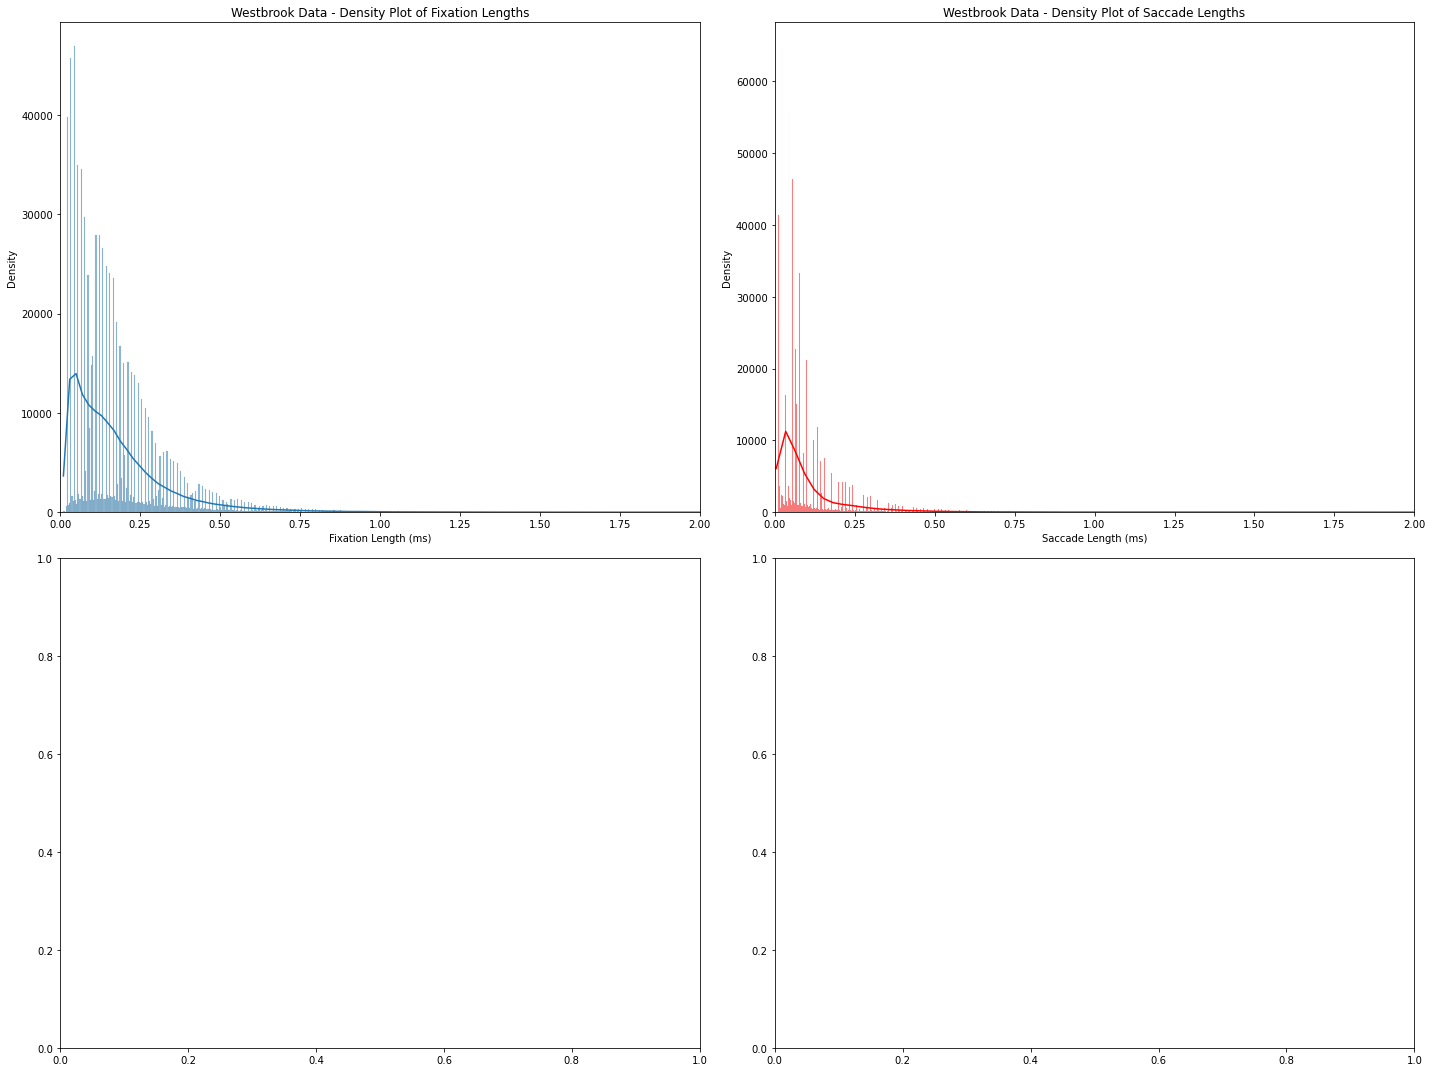

In [168]:
# Step 2: Create a density plot and histogram of fixation and saccade lengths
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

# axs[0].hist(fixation_durations,  bins=155,color='blue', alpha=0.7, label='Fixation Lengths')
sns.histplot(fixation_durations, kde=True, ax = axs[0,0])
axs[0,0].set_title('Westbrook Data - Density Plot of Fixation Lengths')
axs[0,0].set_xlabel('Fixation Length (ms)')
axs[0,0].set_ylabel('Density')
axs[0,0].set_xlim(0,2)

# axs[1].hist(saccade_durations, bins=155,  color='red', alpha=0.7, label='Saccade Lengths')
sns.histplot(saccade_durations, kde=True,color='red', ax = axs[0,1])
axs[0,1].set_title('Westbrook Data - Density Plot of Saccade Lengths')
axs[0,1].set_xlabel('Saccade Length (ms)')
axs[0,1].set_ylabel('Density')
axs[0,1].set_xlim(0,2)


# # axs[0].hist(fixation_durations,  bins=155,color='blue', alpha=0.7, label='Fixation Lengths')
# sns.histplot(fixation_durations2, kde=True, ax = axs[1,0])
# axs[1,0].set_title('Debbies Data - Density Plot of Fixation Lengths')
# axs[1,0].set_xlabel('Fixation Length (ms)')
# axs[1,0].set_ylabel('Density')
# axs[1,0].set_xlim(0,2)

# # axs[1].hist(saccade_durations, bins=155,  color='red', alpha=0.7, label='Saccade Lengths')
# sns.histplot(saccade_durations2, kde=True, color='red',ax = axs[1,1])
# axs[1,1].set_title('Debbies Data - Density Plot of Saccade Lengths')
# axs[1,1].set_xlabel('Saccade Length (ms)')
# axs[1,1].set_ylabel('Density')
# axs[1,1].set_xlim(0,2)

plt.tight_layout()
plt.show()

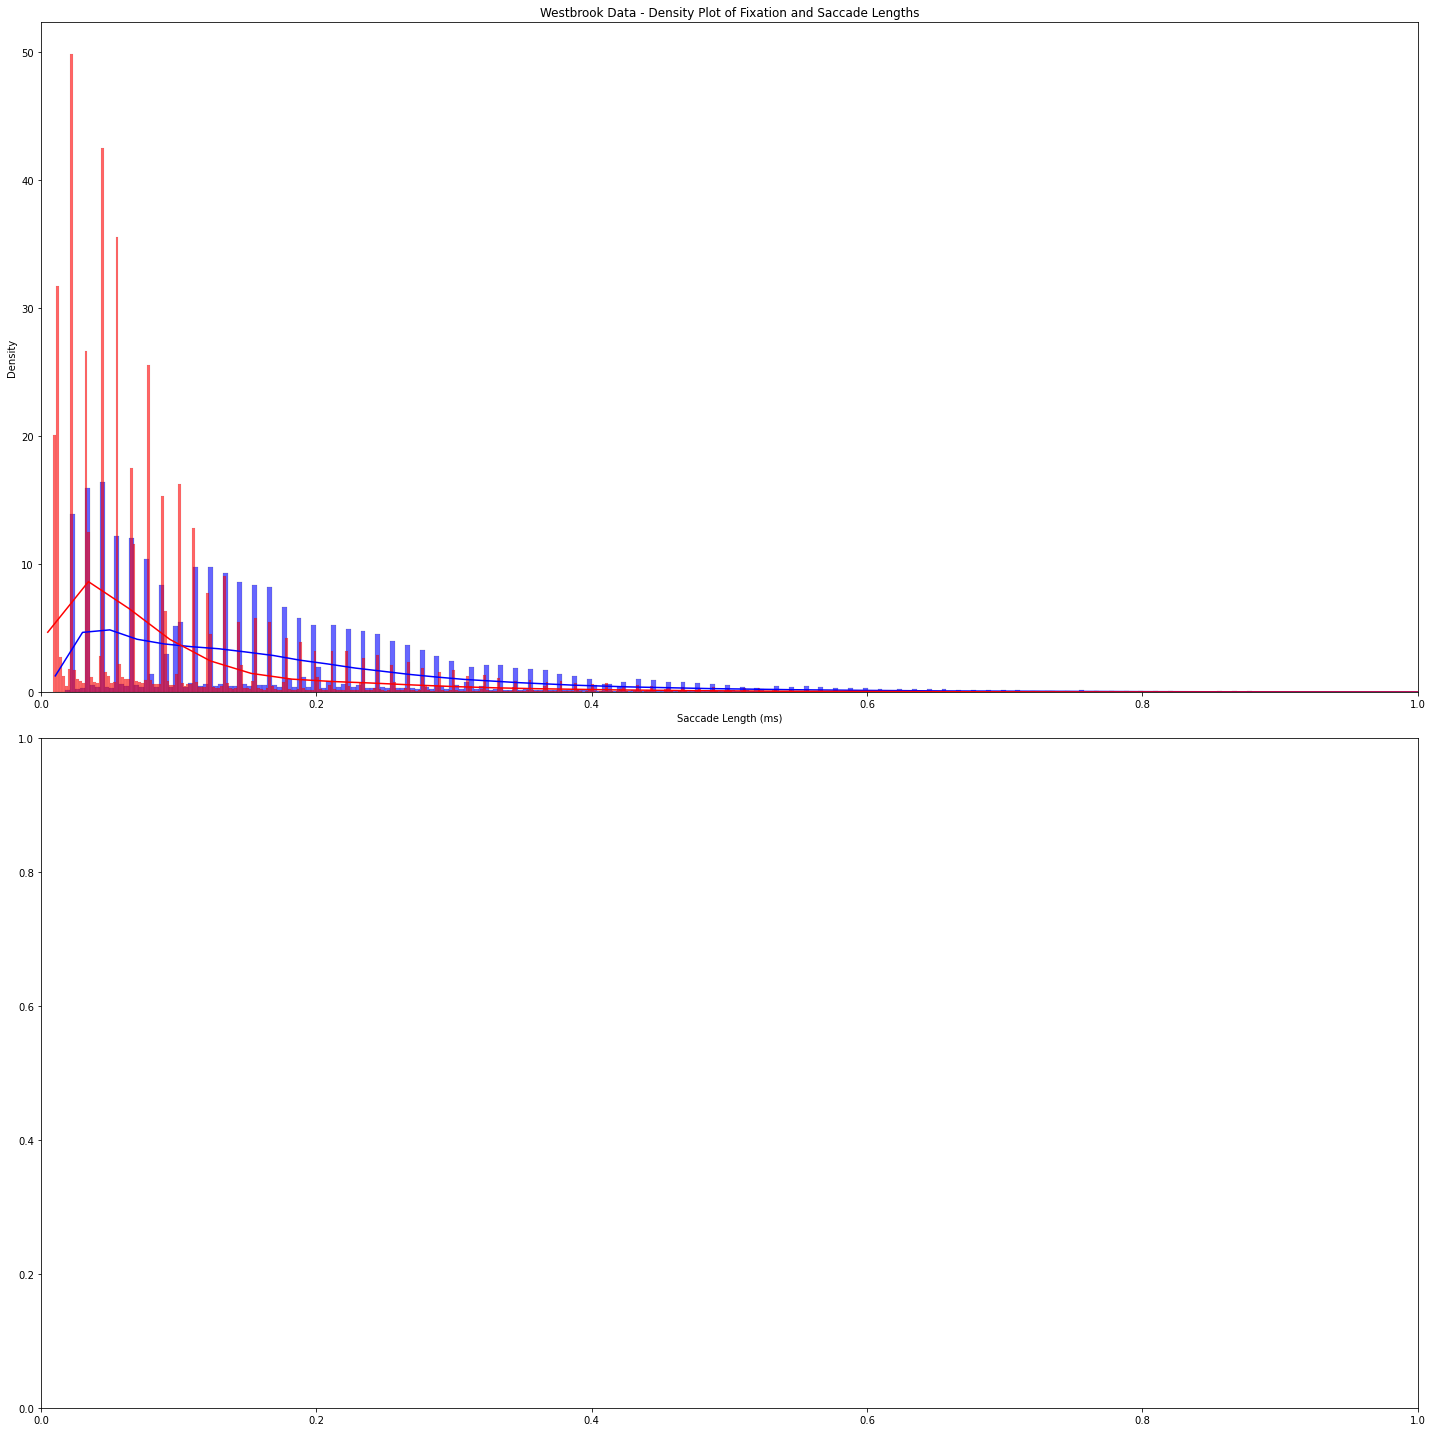

In [169]:


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

# Plot histogram and density plot for fixation durations
sns.histplot(fixation_durations, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[0] )
sns.histplot(saccade_durations, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[0])

axs[0].set_title('Westbrook Data - Density Plot of Fixation and Saccade Lengths')
axs[0].set_xlabel('Saccade Length (ms)')
axs[0].set_ylabel('Density')
axs[0].set_xlim(0,1)


# sns.histplot(fixation_durations2, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[1] )
# sns.histplot(saccade_durations2, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[1])

# axs[1].set_title('Debbies Data - Density Plot of Fixation and Saccade Lengths')
# axs[1].set_xlabel('Saccade Length (ms)')
# axs[1].set_ylabel('Density')
# axs[1].set_xlim(0,1)
# plt.legend()


# Show plot
plt.tight_layout()
plt.show()

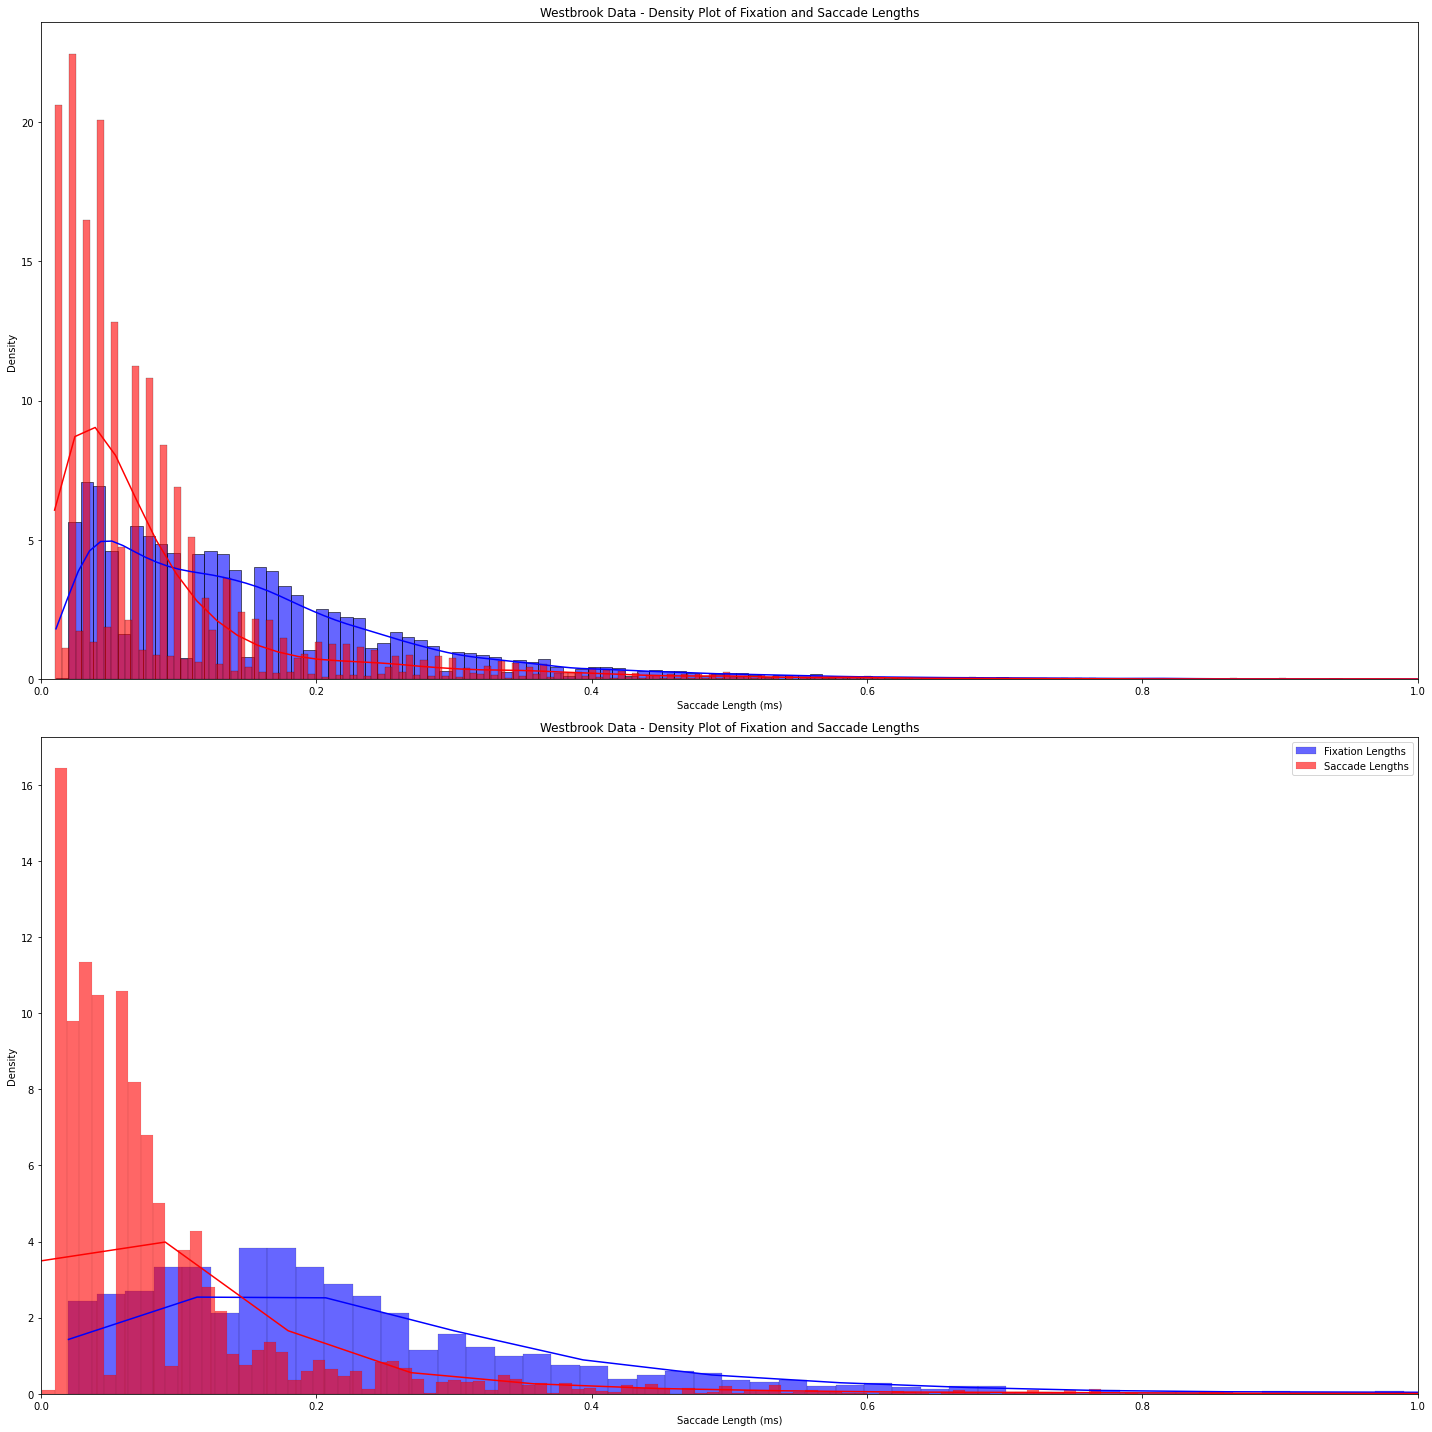

In [221]:


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 20))

# Plot histogram and density plot for fixation durations
sns.histplot(fixation_durations, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[0] )
sns.histplot(saccade_durations, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[0])

axs[0].set_title('Westbrook Data - Density Plot of Fixation and Saccade Lengths')
axs[0].set_xlabel('Saccade Length (ms)')
axs[0].set_ylabel('Density')
axs[0].set_xlim(0,1)


sns.histplot(fixation_durations2, bins='auto', kde=True, color='blue', label='Fixation Lengths', alpha=0.6, stat="density", ax = axs[1] )
sns.histplot(saccade_durations2, bins='auto', kde=True, color='red', label='Saccade Lengths', alpha=0.6, stat="density", ax = axs[1])

axs[1].set_title('Debbies Data - Density Plot of Fixation and Saccade Lengths')
axs[1].set_xlabel('Saccade Length (ms)')
axs[1].set_ylabel('Density')
axs[1].set_xlim(0,1)
plt.legend()


# Show plot
plt.tight_layout()
plt.show()

mean fixation duration (ms) =  158.9314601384161
mean saccade duration  (ms) =  96.09192686124473
-----------------------
median fixation duration (ms) =  125.48995018005371
median saccade duration  (ms) =  55.56011199950106
-----------------------
33202
27172
-----------------------
Sum fixation durations =  5276.842339515685
Sum saccade durations =  2611.009836673739
Sum all durations =  7887.852176189424
-----------------------
Fraction fixation durations of total data =  0.6689834218045523
Fraction saccade durations of total data =  0.33101657819544766


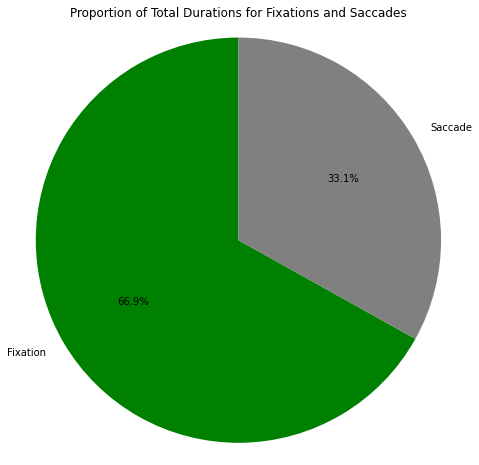

In [206]:

print("mean fixation duration (ms) = ", np.mean(fixation_durations)*1000)
print("mean saccade duration  (ms) = ",np.mean(saccade_durations)*1000)

print("-----------------------")
print("median fixation duration (ms) = ",np.median(fixation_durations)*1000)
print("median saccade duration  (ms) = ",np.median(saccade_durations)*1000)

print("-----------------------")

print(len(fixation_durations))
print(len(saccade_durations))


sum_fixation = sum(fixation_durations)
sum_saccade = sum(saccade_durations)
total_durations = sum_fixation + sum_saccade

print("-----------------------")
print("Sum fixation durations = ",sum_fixation)
print("Sum saccade durations = ", sum_saccade)
print("Sum all durations = ",total_durations)

print("-----------------------")
print("Fraction fixation durations of total data = ", (sum_fixation/total_durations))
print("Fraction saccade durations of total data = ", (sum_saccade / total_durations))

# Step 2: Create a pie chart
labels = ['Fixation', 'Saccade']
sizes = [sum_fixation, sum_saccade]
colors = ['green', 'grey']
explode = (0.1, 0)  # explode the first slice for emphasis

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle= 90)
plt.title('Proportion of Total Durations for Fixations and Saccades')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Show plot
plt.show()

mean fixation duration (ms) =  242.03439515341043
mean saccade duration  (ms) =  104.81775426219792
-----------------------
median fixation duration (ms) =  184.00000000008276
median saccade duration  (ms) =  56.00000000004002
-----------------------
5117
5103
-----------------------
Sum fixation durations =  1238.4900000000011
Sum saccade durations =  534.884999999996
Sum all durations =  1773.3749999999973
-----------------------
Fraction fixation durations of total data =  0.6983802072319747
Fraction saccade durations of total data =  0.3016197927680253


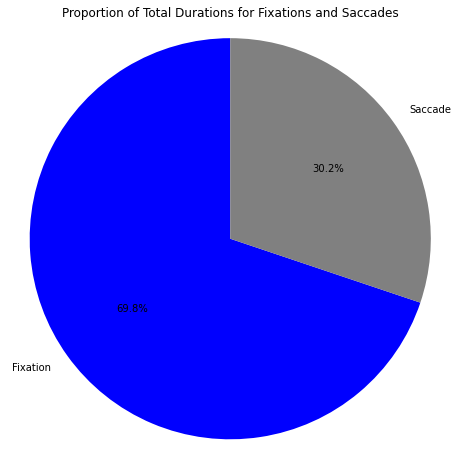

In [226]:

print("mean fixation duration (ms) = ", np.mean(fixation_durations2)*1000)
print("mean saccade duration  (ms) = ",np.mean(saccade_durations2)*1000)

print("-----------------------")
print("median fixation duration (ms) = ",np.median(fixation_durations2)*1000)
print("median saccade duration  (ms) = ",np.median(saccade_durations2)*1000)

print("-----------------------")

print(len(fixation_durations2))
print(len(saccade_durations2))


sum_fixation = sum(fixation_durations2)
sum_saccade = sum(saccade_durations2)
total_durations = sum_fixation + sum_saccade

print("-----------------------")
print("Sum fixation durations = ",sum_fixation)
print("Sum saccade durations = ", sum_saccade)
print("Sum all durations = ",total_durations)

print("-----------------------")
print("Fraction fixation durations of total data = ", (sum_fixation/total_durations))
print("Fraction saccade durations of total data = ", (sum_saccade / total_durations))

# Step 2: Create a pie chart
labels = ['Fixation', 'Saccade']
sizes = [sum_fixation, sum_saccade]
colors = ['blue', 'grey']
explode = (0.1, 0)  # explode the first slice for emphasis

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle= 90)
plt.title('Proportion of Total Durations for Fixations and Saccades')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


# Show plot
plt.show()

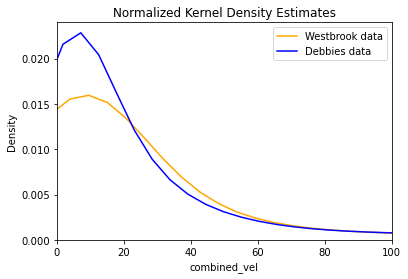

In [223]:
variable_name = 'combined_vel'

sns.kdeplot(data[variable_name], label='Westbrook data', color='orange')
sns.kdeplot(goodData[variable_name], label='Debbies data', color='blue')



plt.xlabel(variable_name)
plt.ylabel('Density')
plt.title('Normalized Kernel Density Estimates')
plt.legend()

plt.xlim(0, 100)

plt.show()

In [232]:
file2 = "1004_Session_1_ET_1_interval_mad_wobig.csv"
int_data = pd.read_csv(os.path.join(data_savepath_intervals, file2))

goodInterval = pd.read_csv('E:/WestbrookProject/DebbiesData//interval_mad_wobig_70656182-09b3-4c19-9ae2-0a2ab2e19fed.csv')


(0.0, 250.0)

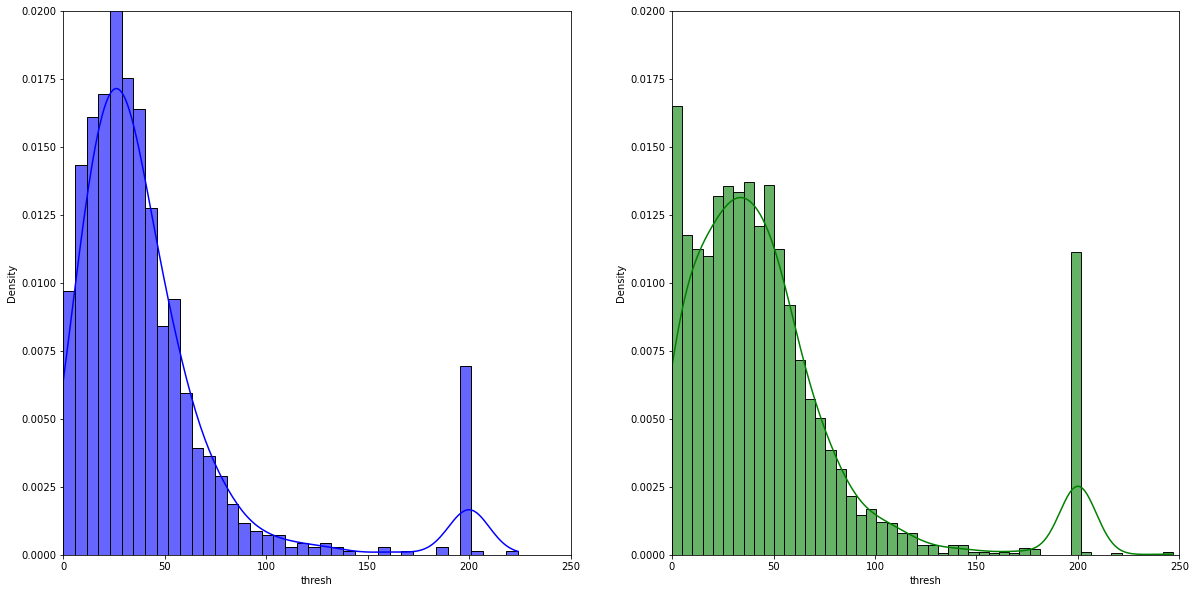

In [241]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.histplot(int_data["thresh"], bins='auto', kde=True, color='blue', label='Threshs', alpha=0.6, stat="density", ax = axs[0])
axs[0].set_ylim(0, 0.02)
axs[0].set_xlim(0, 250)
sns.histplot(goodInterval["thresh"], bins='auto', kde=True, color='green', label='Threshs', alpha=0.6, stat="density",ax = axs[1])
axs[1].set_ylim(0 ,0.02)
axs[1].set_xlim(0, 250)

In [231]:
print('--------- median all velocities----------')
print(np.nanmedian(data['combined_vel']))
print(np.nanmedian(goodData['combined_vel']))

print('--------- mean all velocities----------')
print(np.mean(data['combined_vel']))
print(np.mean(goodData['combined_vel']))


print('--------- 0s in velocities----------')
print((data['combined_vel']== 0).sum()/len(data))
print((goodData['combined_vel']== 0).sum()/len(goodData))


print('--------- NaNs in velocities----------')
print(data['combined_vel'].isna().sum()/len(data))
print(goodData['combined_vel'].isna().sum()/len(goodData))

--------- median all velocities----------
10.616655872568824
10.67012299410869
--------- mean all velocities----------
56.52722392317094
45.063388349829836
--------- 0s in velocities----------
0.0005747727035217891
0.0019456094081023822
--------- NaNs in velocities----------
0.004807189884000418
0.013662501621341173


---------------------------------
max sampling rate 1  201.6201509397683
max sampling rate 2  1000.0000002510205
---------------------------------
mean sampling rate 1  63.764955510773426
mean sampling rate 2  85.79712172495128
---------------------------------
median sampling rate 1  87.64243475353658
median sampling rate 2  90.90909090912662
---------------------------------


Text(0.5, 1.0, 'both sampling rates')

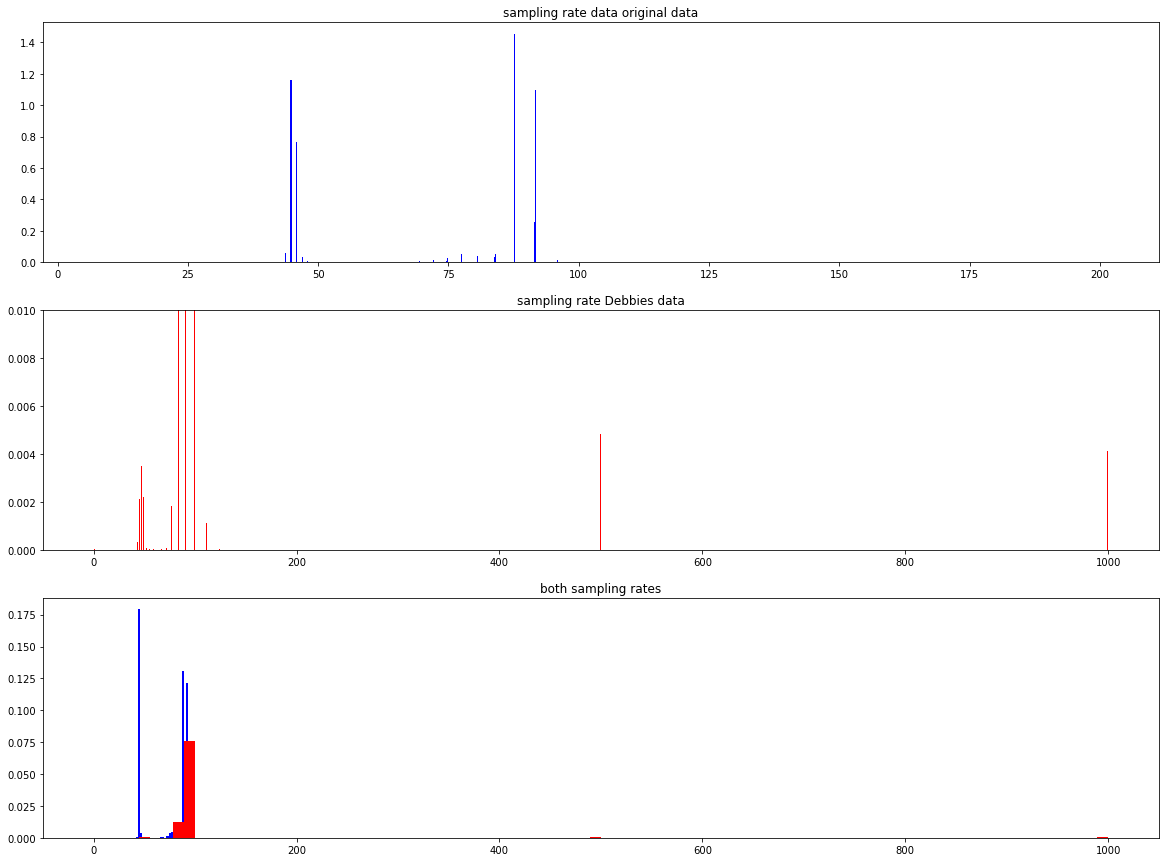

In [265]:
samplingRate1 = data['timeStampDataPointStart'].diff()
samplingRate2 = goodData['time'].diff()

print("---------------------------------")

print("max sampling rate 1 ", 1/np.nanmin(samplingRate1))
print("max sampling rate 2 ", 1/np.nanmin(samplingRate2))
print("---------------------------------")

print("mean sampling rate 1 ", 1/np.nanmean(samplingRate1))
print("mean sampling rate 2 ", 1/np.nanmean(samplingRate2))
print("---------------------------------")

print("median sampling rate 1 ", 1/np.nanmedian(samplingRate1))
print("median sampling rate 2 ", 1/np.nanmedian(samplingRate2))

print("---------------------------------")



fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 15))

axes[0].hist(1/samplingRate1, color='blue', bins = 1000, density = True)
axes[0].set_title('sampling rate data original data')


axes[1].hist(1/samplingRate2, color= 'red', bins = 1000, density = True)

axes[1].set_title('sampling rate Debbies data')
axes[1].set_ylim(0, 0.01)

axes[2].hist(1/samplingRate1, color='blue', bins = 90, density = True)
axes[2].hist(1/samplingRate2, color= 'red', bins = 90, density = True)

axes[2].set_title('both sampling rates')

MemoryError: Unable to allocate 106. TiB for an array with shape (14501269310888,) and data type float64

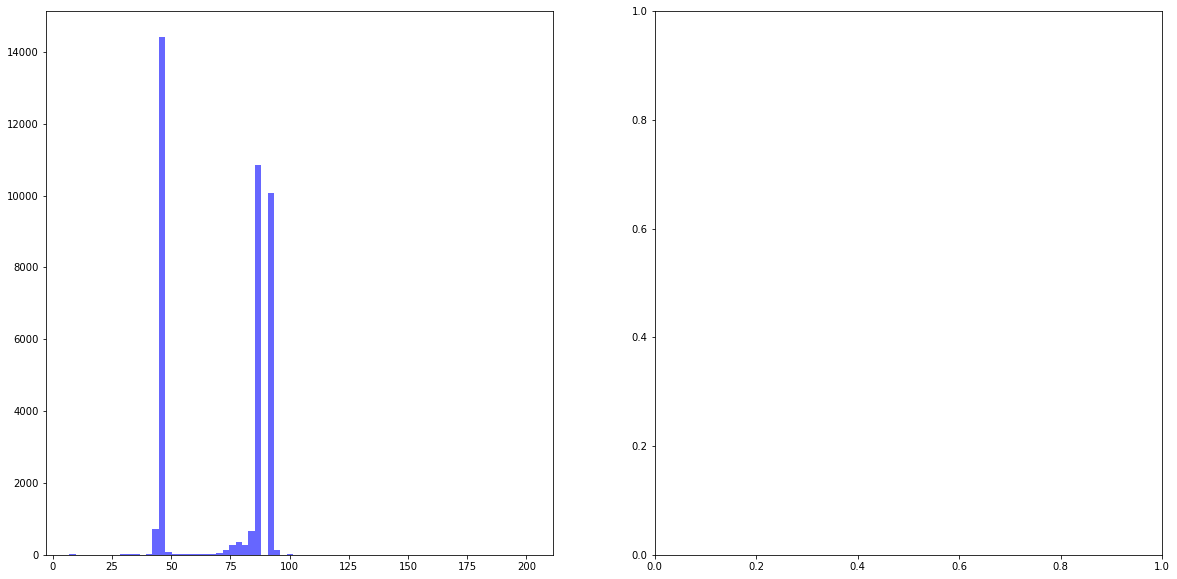

In [277]:
# Create a single subplot
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plot histograms and density plots for both datasets on the same axis
axs[0].hist(1/samplingRate1, bins='auto', color='blue',  alpha=0.6)
axs[1].hist(1/samplingRate2, bins='auto', color='red',  alpha=0.6)
# # Set titles and labels
# ax[0].set_title('Density Plot of Sampling Rates')
# ax[0].set_xlabel('Sampling Rate (ms)')
# ax[0].set_ylabel('Density')
# ax[0].legend()

# Show plot
plt.tight_layout()
plt.show()

In [140]:
file= "1008_Session_1_ET_1_data_processed_gazes.csv"
data = pd.read_csv(os.path.join(data_savepath_processed_gazes, file))

In [136]:

pd.set_option('display.max_columns', None)

# # Assuming 'data' is your DataFrame
data_head = data.head(55)

# Display head horizontally
with pd.option_context('display.max_rows', None, 'display.width', 1000):
#     display(data_head)
    display(data.iloc[100:170])



,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,goodData,long_events
0,0.000000,0.00000,1.620048e+09,1.620048e+09,1.620048e+09,0.890653,0.983545,4.963711,4.486682,31.0,31.0,3.0,-59.009783,2.406623,34.677778,0.253288,-0.141500,0.955491,-0.051065,-0.123540,0.989582,-58.952024,2.407876,34.681662,0.268104,-0.137186,0.952069,-0.035721,-0.119908,0.990699,-59.014553,2.406419,34.677969,0.248464,-0.143172,0.956533,-0.056050,-0.124992,0.989154,-58.981634,2.401428,34.712397,0.299869,-0.015910,0.952444,0.951782,0.045788,-0.298895,0.911639,17.452760,2.624739,-0.038907,0.997484,0.028913,-59.020839,0.857525,34.743407,-58

In [141]:
data_old = data.copy()

In [180]:
time = data["timeStampRS"].tolist()

# get individual coordinates
# position
Xcorr_position = data["eyePositionCombinedWorld_x"].tolist()
Ycorr_position = data["eyePositionCombinedWorld_y"].tolist()
Zcorr_position = data["eyePositionCombinedWorld_z"].tolist()
subj = list(zip(Xcorr_position, Ycorr_position, Zcorr_position))

# hpoo
hpooX = data["processedCollider_hitPointOnObject_x"].tolist()
hpooY = data["processedCollider_hitPointOnObject_y"].tolist()
hpooZ = data["processedCollider_hitPointOnObject_z"].tolist()

hpoo = list(zip(hpooX, hpooY, hpooZ))

# v_gaze_vec: get difference in hpoo
v_vX = pd.DataFrame(hpooX).apply(lambda x: x.diff())[0].tolist()
v_vY = pd.DataFrame(hpooY).apply(lambda x: x.diff())[0].tolist()
v_vZ = pd.DataFrame(hpooZ).apply(lambda x: x.diff())[0].tolist()

# get difference in time:
ts = pd.DataFrame(time).apply(lambda x: x.diff())[0].tolist()

v_gaze_vec = list(zip(v_vX, v_vY, v_vZ))

# gaze_vec(t) is a unit vector in the direction of the gaze (eye+head) in world coordinates
g_vec = [np.array(hpoo[v] - np.array(subj[v])) for v in range(len(subj))]
gaze_vec = [np.array(v) / np.linalg.norm(np.array(v)) for v in g_vec]
# display(np.linalg.norm(gaze_vec[1]))

# v_gaze_inplane: is a scalar indicating the velocity in world coordinates at the location that is gazed at orthogonal to the gaze axis.
# v_gaze_inplane(t) = ||v_gaze_vec(t) - (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))||:
# z1 = (<v_gaze_vec(t), gaze_vec(t)>)
z1 = [
    np.array(v_gaze_vec[t]).dot(np.array(gaze_vec[t]))
    for t in range(len(v_vX))
]

# z = (<v_gaze_vec(t), gaze_vec(t)> * gaze_vec(t))
z = [z1[t] * np.array(gaze_vec[t]) for t in range(len(v_vX))]

# ||v_gaze_vec(t) - z||
v_gaze_inplane = [
    np.linalg.norm((np.array(v_gaze_vec[t]) - z[t]).tolist())
    for t in range(len(v_gaze_vec))
]
# w_gaze(t) = arctan2(||subject_vec(t) - hpoo_vec(t)||, v_gaze_inplane)

# sub_hpoo = ||subject_vec(t) - hpoo_vec(t)||
sub_hpoo = [
    np.linalg.norm(np.array(subj[t]) - np.array(hpoo[t]))
    for t in range(len(hpoo))
]

# arctan2(v_gaze_inplane, sub_hpoo)
w_gaze = np.arctan2(v_gaze_inplane, sub_hpoo).tolist()

# turn angle of radians into degrees
w_gaze = [(w / ts[idx] * 180 / math.pi) for idx, w in enumerate(w_gaze)]
# w_gaze = [(w*180/math.pi) for idx,w in enumerate(w_gaze)]

# add 0 to first sample, since NaN will throw an error in the Savitzky-Golay filter
w_gaze[0]=0

# save df --> to facilitate runtime, save data only in last processing function
data["combined_vel3"] = w_gaze

In [195]:
data.iloc[210:240]

,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH
210,2.333333,2.33219,1.620048e+09,1.620048e+09,1.620048e+09,0.994674,0.994558,4.216385,3.963233,31.0,31.0,3.0,-59.043156,2.419906,34.718983,0.279226,0.235931,0.931067,-0.065214,0.157181,0.985655,-59.040675,2.419856,34.719117,0.279897,0.236308,0.930770,-0.064468,0.157533,0.985648,-59.103033,2.418822,34.714891,0.264598,0.228341,0.937212,-0.081333,0.150143,0.985560,-59.070865,2.414201,34.749512,0.355082,0.082916,0.931347,0.932916,0.035555,-0.358845,355.309965,20.873470,2.044597,-0.062856,0.996106,-0.064717,-59.110854,0.858833,34.796396,-58.956406,1.916139,34.969

In [144]:
data_old.head(10)

,timeStampRS,timeStampDataPointStart_converted,timeStampDataPointStart,timeStampDataPointEnd,timeStampGetVerboseData,eyeOpennessLeft,eyeOpennessRight,pupilDiameterMillimetersLeft,pupilDiameterMillimetersRight,leftGazeValidityBitmask,rightGazeValidityBitmask,combinedGazeValidityBitmask,eyePositionCombinedWorld_x,eyePositionCombinedWorld_y,eyePositionCombinedWorld_z,eyeDirectionCombinedWorld_x,eyeDirectionCombinedWorld_y,eyeDirectionCombinedWorld_z,eyeDirectionCombinedLocal_x,eyeDirectionCombinedLocal_y,eyeDirectionCombinedLocal_z,eyePositionLeftWorld_x,eyePositionLeftWorld_y,eyePositionLeftWorld_z,eyeDirectionLeftWorld_x,eyeDirectionLeftWorld_y,eyeDirectionLeftWorld_z,eyeDirectionLeftLocal_x,eyeDirectionLeftLocal_y,eyeDirectionLeftLocal_z,eyePositionRightWorld_x,eyePositionRightWorld_y,eyePositionRightWorld_z,eyeDirectionRightWorld_x,eyeDirectionRightWorld_y,eyeDirectionRightWorld_z,eyeDirectionRightLocal_x,eyeDirectionRightLocal_y,eyeDirectionRightLocal_z,hmdPosition_x,hmdPosition_y,hmdPosition_z,hmdDirectionForward_x,hmdDirectionForward_y,hmdDirectionForward_z,hmdDirectionRight_x,hmdDirectionRight_y,hmdDirectionRight_z,hmdRotation_x,hmdRotation_y,hmdRotation_z,hmdDirectionUp_x,hmdDirectionUp_y,hmdDirectionUp_z,handLeftPosition_x,handLeftPosition_y,handLeftPosition_z,handRightPosition_x,handRightPosition_y,handRightPosition_z,handRightRotation_x,handRightRotation_y,handRightRotation_z,handRightDirectionForward_x,handRightDirectionForward_y,handRightDirectionForward_z,handRightDirectionRight_x,handRightDirectionRight_y,handRightDirectionRight_z,handRightDirectionUp_x,handRightDirectionUp_y,handRightDirectionUp_z,playerBodyPosition_x,playerBodyPosition_y,playerBodyPosition_z,bodyTrackerPosition_x,bodyTrackerPosition_y,bodyTrackerPosition_z,bodyTrackerRotation_x,bodyTrackerRotation_y,bodyTrackerRotation_z,hitObjectColliderName_1,ordinalOfHit_1,hitPointOnObject_x_1,hitPointOnObject_y_1,hitPointOnObject_z_1,hitObjectColliderBoundsCenter_x_1,hitObjectColliderBoundsCenter_y_1,hitObjectColliderBoundsCenter_z_1,hitObjectColliderName_2,ordinalOfHit_2,hitPointOnObject_x_2,hitPointOnObject_y_2,hitPointOnObject_z_2,hitObjectColliderBoundsCenter_x_2,hitObjectColliderBoundsCenter_y_2,hitObjectColliderBoundsCenter_z_2,DataRow,hitObjectColliderisGraffiti_1,hitObjectColliderisGraffiti_2,processedCollider_name,processedCollider_hitPointOnObject_x,processedCollider_hitPointOnObject_y,processedCollider_hitPointOnObject_z,processedCollider_hitObjectColliderBoundsCenter_x,processedCollider_hitObjectColliderBoundsCenter_y,processedCollider_hitObjectColliderBoundsCenter_z,replacedRows,processedColliderIsNH,processedCollider_NH_name,processedCollider_NH_hitPointOnObject_x,processedCollider_NH_hitPointOnObject_y,processedCollider_NH_hitPointOnObject_z,processedCollider_NH_hitObjectColliderBoundsCenter_x,processedCollider_NH_hitObjectColliderBoundsCenter_y,processedCollider_NH_hitObjectColliderBoundsCenter_z,replacedRows_NH,processedCollider_NH_IsNH,cleanData,isBlink,original_processedCollider_hitPointOnObject_x,original_processedCollider_hitPointOnObject_y,original_processedCollider_hitPointOnObject_z,original_processedCollider_NH_hitPointOnObject_x,original_processedCollider_NH_hitPointOnObject_y,original_processedCollider_NH_hitPointOnObject_z,removedData,interpolated,interpolatedHitPoint,combined_vel,thresh,isFix,corrected_vel,events,length,distance,distance_NH,avg_dist,avg_dist_NH,names,namesNH,goodData,long_events
0,0.000000,0.00000,1.620048e+09,1.620048e+09,1.620048e+09,0.890653,0.983545,4.963711,4.486682,31.0,31.0,3.0,-59.009783,2.406623,34.677778,0.253288,-0.141500,0.955491,-0.051065,-0.123540,0.989582,-58.952024,2.407876,34.681662,0.268104,-0.137186,0.952069,-0.035721,-0.119908,0.990699,-59.014553,2.406419,34.677969,0.248464,-0.143172,0.956533,-0.056050,-0.124992,0.989154,-58.981634,2.401428,34.712397,0.299869,-0.015910,0.952444,0.951782,0.045788,-0.298895,0.911639,17.452760,2.624739,-0.038907,0.997484,0.028913,-59.020839,0.857525,34.743407,-58

In [145]:
nan_indexes = data[data['eyeOpennessLeft'].isna()].index.tolist()

In [146]:
print(nan_indexes[:50])

[]
